# Procgen-PPO-RND implementation

PPO-RND implemenetation for the environemnts in the procgen benchmark.

In [1]:
import gym
from gym.wrappers import GrayScaleObservation
from gym.wrappers import FrameStack
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from keras import backend as K
from collections import deque
import random
from matplotlib import pyplot as plt
from threading import Thread
import math

# change keras setting to use the conv2d NN passing the channel first (as returned from the FrameStack wrapper)
K.set_image_data_format('channels_first')

## Memory

Class used to memorize the trajectories and calculate the advantages

In [2]:
class Memory(object):
    
    STATE = 0
    ACTION = 1
    ACTION_PROB = 2
    EXTRINSIC_REWARD = 3
    INTRINSIC_REWARD = 4
    DONE = 5
    
    def __init__(self, n_trajectories, e_gamma = 0.999, i_gamma = 0.99, e_lambda = 0.95, i_lambda = 0.95, discount_rate = 0.99):
        self.trajectories = np.empty(n_trajectories, dtype=object)
        self.e_gamma = e_gamma
        self.i_gamma = i_gamma
        self.e_lambda = e_lambda
        self.i_lambda = i_lambda
        
        self.discount_rate = discount_rate
        
        self.last_pos = 0
        self.rnd_indices = None
        self.n_trajectories = n_trajectories
        
        self.advantages = []
        self.extrinsic_TDresiduals = []
        self.intrinsic_TDresiduals = [] 
        self.extrinsic_discounts = []
        self.intrinsic_discounts = []
        
              
    def collect(self, state, action, action_prob, extrinsic_reward, intrinsic_reward, done, i_episode):
        if (self.trajectories[i_episode] == None):
            self.trajectories[i_episode] = deque(maxlen=N_STEPS)
        self.trajectories[i_episode].append((state, action, action_prob, extrinsic_reward, intrinsic_reward, done))
        
    def calculate_advantages(self, reward_standard_deviation_estimate):
        
        for trajectory in self.trajectories:
            
            advantage_trajectory = [] #list of advantages for each element in a single trajectory
            e_delta = []
            i_delta = []
            e_G = []
            i_G = []

            old_v_e_t = ppo.return_v_extrinsic_values(trajectory[-1][self.STATE])[0]
            e_discount = 0
            e_advantage = 0
            
            old_v_i_t = ppo.return_v_intrinsic_values(trajectory[-1][self.STATE])[0]
            i_discount = 0
            i_advantage = 0
            
            for i in range(len(trajectory)-2,-1,-1):
                v_e_t = ppo.return_v_extrinsic_values(trajectory[i][self.STATE])[0]
                e_delta.append(trajectory[i+1][self.EXTRINSIC_REWARD] + 
                               self.e_gamma*old_v_e_t - v_e_t)
                e_discount = trajectory[i+1][self.EXTRINSIC_REWARD] + self.discount_rate*e_discount
                e_advantage = e_delta[-1] + self.e_gamma*self.e_lambda*e_advantage                                    
                
                e_G.append(e_discount)
                    
                old_v_e_t = v_e_t
                
                normalized_intrinsic_reward = trajectory[i+1][self.INTRINSIC_REWARD] / reward_standard_deviation_estimate
                v_i_t = ppo.return_v_intrinsic_values(trajectory[i][self.STATE])[0]
                i_delta.append(normalized_intrinsic_reward + 
                               self.i_gamma*old_v_i_t - v_i_t)
                i_discount = normalized_intrinsic_reward + self.discount_rate*i_discount
                i_advantage = i_delta[-1] + self.i_gamma*self.i_lambda*i_advantage                                    
                  
                i_G.append(i_discount)
                
                old_v_i_t = v_i_t
                
                advantage_trajectory.append(i_advantage + e_advantage)
                                                                                                                                                                       
            self.extrinsic_TDresiduals.append(e_delta)
            self.intrinsic_TDresiduals.append(i_delta)
            
            self.extrinsic_discounts.append(e_G)
            self.intrinsic_discounts.append(i_G)
                           
            self.advantages.append(advantage_trajectory)
        
    #pick a random batch example from the flatten list of trajectories
    def sample_experiences(self, batch_size):
        
        if (self.rnd_indices == None):
            self.rnd_indices = [(i,j) for i in range(self.n_trajectories) for j in range(len(self.trajectories[i])-1) ]
            random.shuffle(self.rnd_indices)
        
        if (self.last_pos + batch_size < len(self.rnd_indices)):
            indices = self.rnd_indices[self.last_pos:self.last_pos + batch_size]
            self.last_pos = self.last_pos + batch_size
        else:
            indices = self.rnd_indices[self.last_pos:]
            self.last_pos = 0
            random.shuffle(self.rnd_indices)
                 
        
        batch = [(self.trajectories[i][j][self.STATE],
                  self.trajectories[i][j][self.ACTION], 
                  self.trajectories[i][j][self.ACTION_PROB], 
                  self.trajectories[i][j][self.EXTRINSIC_REWARD],
                  self.trajectories[i][j][self.INTRINSIC_REWARD],
                  self.advantages[i][len(self.trajectories[i]) - 2 - j],
                  self.extrinsic_TDresiduals[i][len(self.trajectories[i]) - 2 - j],
                  self.intrinsic_TDresiduals[i][len(self.trajectories[i]) - 2 - j],
                  self.extrinsic_discounts[i][len(self.trajectories[i]) - 2 - j],
                  self.intrinsic_discounts[i][len(self.trajectories[i]) - 2 - j],
                  self.trajectories[i][j][self.DONE], 
                 ) 
                 for i,j in indices] 
        
        states, actions, actions_prob, e_rewards, i_rewards, advantages, e_TDresiduals, i_TDresiduals, e_discounts, i_discounts, dones = [np.array([experience[field_index] for experience in batch]) for field_index in range(11)]
        return states, actions, actions_prob, e_rewards, i_rewards, advantages, e_TDresiduals, i_TDresiduals, e_discounts, i_discounts, dones
        
    def reset(self):
        for trajectory in self.trajectories:
            trajectory.clear()
            
        self.rnd_indices = None
        
        self.advantages.clear()
        self.extrinsic_TDresiduals.clear()
        self.intrinsic_TDresiduals.clear()
        self.extrinsic_discounts.clear()
        self.intrinsic_discounts.clear()
        self.last_pos = 0

In [3]:
class RND(object):
    
    input_shape = [1,64,64] 
    n_outputs = 200
    
    N_intrinsic_rewards = 0 #number of intrinsic reward received
    intrinisc_reward_mean = 0.0 #mean of the intrinsic rewards received
    reward_M2 = 0.0 #sum of squares of differences from the current mean
    
    N_observations = 0 #number of observations received
    observations_mean = np.zeros([64,64] ,'float64') #mean of the observations received
    observation_M2 = np.zeros([64,64] ,'float64') #sum of squares of differences from the current mean
    
    def __init__(self, env, n_normalization_steps = 40):
        self.target = self.create_target()
        self.predictor = self.create_predictor()
        
        self.MSE = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        
        self.initialize_standard_deviation_estimate(env, n_normalization_steps)
        
    #create the NN of the target
    def create_target(self):
        target = keras.Sequential([
            keras.layers.Conv2D(filters=16, kernel_size = (3,3), strides=2, activation="relu", input_shape = self.input_shape),
            keras.layers.Conv2D(filters=32, kernel_size = (4,4), strides=2, activation="relu"),
            keras.layers.Conv2D(filters=32, kernel_size = (3,3), strides=1, activation="relu"),
            keras.layers.Dense(256),
            tf.keras.layers.Flatten(),
            keras.layers.Dense(self.n_outputs) ])
        return target
        
    #create the NN of the predictor
    def create_predictor(self):
        predictor = keras.Sequential([
            keras.layers.Conv2D(filters=16, kernel_size = (3,3), strides=2, activation="relu", input_shape = self.input_shape),
            keras.layers.Conv2D(filters=32, kernel_size = (4,4), strides=2, activation="relu"),
            keras.layers.Conv2D(filters=32, kernel_size = (3,3), strides=1, activation="relu"),
            keras.layers.Dense(256),
            tf.keras.layers.Flatten(),
            keras.layers.Dense(self.n_outputs) ])
        return predictor
    
    def train_predictor(self, observations):
        # extrinsic critic (rewards from the envirnoment)
        observations = np.array(observations)
        observations = self.normalize_observations(observations)
        # covert shape [BATCH_SIZE, 4, 84, 84] in [BATCH_SIZE,1,84,84]
        observations = [observation[-1,0:observation.shape[1], 0:observation.shape[2]] for observation in observations]
        observations = tf.expand_dims(observations, axis = 1)
        target_values = self.target.predict(observations)
        with tf.GradientTape() as tape:
            all_values = self.predictor(observations)
            loss = tf.reduce_mean(self.MSE(target_values, all_values))
        grads = tape.gradient(loss, self.predictor.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.predictor.trainable_variables))
        
    def calculate_intrinsic_reward(self, observation):
        #passing a (4,84,84) stacked frame from the environment
        observation = np.array(observation).astype(np.float32)
        #picking the last frame
        observation = observation[-1, 0:observation.shape[1], 0:observation.shape[2]]
        #normalize the last frame
        s = self.calculate_observation_standard_deviation()
        observation = self.normalize_observation(observation, s)
        #calculate intrinsic reward on the last frame
        observation = tf.expand_dims(observation, axis=0)
        f_target = self.target.predict(tf.expand_dims(observation, axis=0))
        f_predictor = self.predictor.predict(tf.expand_dims(observation, axis=0))
        
        reward =  pow(np.linalg.norm(f_predictor - f_target), 2)*100
            
        return reward
    
    def initialize_standard_deviation_estimate(self, env, n_normalization_steps):
        
        obsevation = env.reset()
        
        for i_step in range(n_normalization_steps):
            observation, reward, done, info = env.step(env.action_space.sample())
            observation = np.array(observation).astype(np.float32)
            for frame in observation:
                self.update_observation_normalization_param(frame)
    
    def update_observation_normalization_param(self, observation):
        #cicle trhough the 4 images that makes up for an observation
        for obs in observation:
            self.N_observations = self.N_observations + 1
            delta = obs - self.observations_mean
            self.observations_mean = self.observations_mean + delta/self.N_observations # mean_N = mean_{N-1} + (obs_t - mean_{N-1}) / N
            self.observation_M2 = self.observation_M2 + delta*(obs - self.observations_mean)
        
    def calculate_observation_standard_deviation(self):
        standard_deviation = np.sqrt( self.observation_M2 / (self.N_observations - 1))
        return standard_deviation
    
    def normalize_observations(self, observations):

        norm_obs = []
        s = self.calculate_observation_standard_deviation()
        for observation in observations:
            norm_obs.append(self.normalize_observation(observation, s))
        normalized_obs = tf.stack([norm_obs[i] for i in range(len(norm_obs))], 0)

        return normalized_obs
    
    def normalize_observation(self, observation, standard_deviation):
        t = observation - self.observations_mean
        normalized_obs = np.clip(np.divide(t, standard_deviation, out=np.zeros_like(t), where=standard_deviation!=0), a_min =-5, a_max = 5)       
        return normalized_obs
    
    #Using welford's algorithm
    def update_reward_normalization_param(self, i_reward):
        self.N_intrinsic_rewards = self.N_intrinsic_rewards + 1
        delta = i_reward - self.intrinisc_reward_mean
        self.intrinisc_reward_mean = self.intrinisc_reward_mean + delta/self.N_intrinsic_rewards # mean_N = mean_{N-1} + (i_t - mean_{N-1}) / N
        self.reward_M2 = self.reward_M2 + delta*(i_reward - self.intrinisc_reward_mean)
        
    def calculate_reward_standard_deviation(self):
        standard_deviation = math.sqrt( self.reward_M2 / (self.N_intrinsic_rewards - 1))
        print("===============================================================")
        print("STANDARD DEVIATION {}".format(standard_deviation))
        print("===============================================================")
        return standard_deviation
    
    def save(self, path = ".\\saved_weights\\rnd\\"):
        self.target.save_weights(path + 'target_weights.h5')
        self.predictor.save_weights(path + 'predictor_weights.h5')
        
    def load(self, path = ".\\saved_weights\\rnd\\"):
        self.target.load_weights(path + 'target_weights.h5')
        self.predictor.load_weights(path + 'predictor_weights.h5')

# PPO class including the exploration bonus

$ s_{t+1} $ and $ r_t = r_{t+1}^{(e)} + r_{t+1}^{(i)} $  are the observed state/reward after the current action $ a_t $.

$ a_{T-1} $ is the last action taken and $ s_T $, $ r_T $ are the last observation/reward.

Actor parameter updated to maximize:
$  L^{CLIP}(\theta) = \hat{\mathbb{E}}_t[min(r_t(\theta)\hat{A}_t, clip(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t) + \beta H_t ] $

Critic parameter update to minimize:
$ L(w) = \sum(\hat{v}(s_t,w) - G_t)^2$

Probability ratio $ r_t(\theta) \doteq $
$ \pi_\theta(a_t | s_t) \over \pi_{\theta_{old}}(a_t | s_t) $

Advantage:
$ \hat{A}_t = \hat{A}_t^{(e)} + \hat{A}_t^{(i)} $

$ \quad \hat{A}_t^{(e)} \doteq \delta_t^{(e)} + (\gamma^{(e)}\lambda^{(e)})\delta_{t+1}^{(e)} + (\gamma^{(e)}\lambda^{(e)})^2\delta_{t+2}^{(e)} + ... + (\gamma^{(e)}\lambda^{(e)})^{T
-t-1}\delta_{T-1}^{(e)} = \delta_t^{(e)} + (\gamma^{(e)}\lambda^{(e)})\hat{A}_{t+1}^{(e)}$

$ \quad \hat{A}_t^{(i)} \doteq \delta_t^{(i)} + (\gamma^{(i)}\lambda^{(i)})\delta_{t+1}^{(i)} + (\gamma^{(i)}\lambda^{(i)})^2\delta_{t+2}^{(i)} + ... + (\gamma^{(i)}\lambda^{(i)})^{T
-t-1}\delta_{T-1}^{(i)} = \delta_t^{(i)} + (\gamma^{(i)}\lambda^{(i)})\hat{A}_{t+1}^{(i)}$

TD residual:

$ \quad \delta_t^{(e)}  \doteq r_{t+1}^{(e)} + \gamma^{(e)}\hat{v}^{(e)}(s_{t+1},w) - \hat{v}^{(e)}(s_t,w) $

$ \quad \delta_t^{(i)}  \doteq r_{t+1}^{(i)} + \gamma^{(i)}\hat{v}^{(i)}(s_{t+1},w) - \hat{v}^{(i)}(s_t,w) $ 

Discount return:

$ \quad G_t^{(e)} \doteq r_{t+1}^{(e)} + \gamma^{(e)} r_{t+2}^{(e)} + (\gamma^{(e)})^2 r_{t+3} + ... + (\gamma^{(e)})^{T-t+1} r_{T-t-1}^{(e)} = r_t^{(e)} + \gamma^{(e)} G_{t+1}^{(e)} $

$ \quad G_t^{(i)} \doteq r_{t+1}^{(i)} + \gamma^{(i)} r_{t+2}^{(i)} + (\gamma^{(i)})^2 r_{t+3} + ... + (\gamma^{(i)})^{T-t+1} r_{T-t-1}^{(i)} = r_t^{(i)} + \gamma^{(i)} G_{t+1}^{(i)} $

Entropy:
$ H_t \doteq $
$ - \sum \pi(a_t|s_t,\theta)log_2(\pi_{\theta}(a_t|s_t)) $

In [4]:
class PPO(object):
    
    input_shape = [4,64,64] 
    n_outputs = 9 #15 #wrapped_env.action_space.n
    
    def __init__(self, env, n_episodes = 1, train_steps = 100, epsilon = 0.1, alpha = 1, gamma = 0.99, e_lambda_par = 0.98, i_lambda_par = 0.98, n_normalization_steps = 300, train_predictor_keeping_prob = 0.5, beta = 1e-3):
        self.actor = self.create_actor()
        self.intrinsic_critic = self.create_critic()
        self.extrinsic_critic = self.create_critic()
        
        self.MSE = tf.keras.losses.mean_squared_error
        
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        self.extrinsic_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
        self.intrinsic_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.beta = beta
        
        self.train_steps = train_steps
        self.train_predictor_keeping_prob = train_predictor_keeping_prob
        
        self.memory = Memory(n_episodes)
        
        self.rnd = RND(env, n_normalization_steps)
        
    #create the NN of the actor
    # Given the state returns the probability of each action
    def create_actor(self):
        initializer = tf.keras.initializers.GlorotNormal()
        actor = keras.Sequential([
            keras.layers.Conv2D(filters=16, kernel_size = (3,3), strides=2, activation="tanh", input_shape = self.input_shape, kernel_initializer=initializer),
            keras.layers.Conv2D(filters=32, kernel_size = (4,4), strides=2, activation="tanh", kernel_initializer=initializer),
            keras.layers.Conv2D(filters=32, kernel_size = (2,2), strides=1, activation="tanh", kernel_initializer=initializer),
            keras.layers.Dense(256, kernel_initializer=initializer),
            tf.keras.layers.Flatten(),
            keras.layers.Dense(self.n_outputs, kernel_initializer=initializer, activation = 'softmax') ])
        return actor
       
    #create the NN of the critic
    # Given the state returns the value function
    def create_critic(self):
        critic = keras.Sequential([
            keras.layers.Conv2D(filters=16, kernel_size = (3,3), strides=2, activation="relu", input_shape = self.input_shape),
            keras.layers.Conv2D(filters=32, kernel_size = (4,4), strides=2, activation="relu"),
            keras.layers.Conv2D(filters=32, kernel_size = (3,3), strides=1, activation="relu"),
            keras.layers.Dense(256),
            tf.keras.layers.Flatten(),
            keras.layers.Dense(1) ])
        
        return critic
      
    def play_one_step(self, env, observation, reward, i_episode, step):
        action, action_prob = self.select_action(observation)
        next_observation, next_reward, done, info = env.step(action)
        
        #the normalization of the intrinisc reward after before training
        i_reward = self.rnd.calculate_intrinsic_reward(observation)
        
        self.rnd.update_reward_normalization_param(i_reward)
        self.rnd.update_observation_normalization_param(observation)
        
        self.memory.collect(observation, action, action_prob, reward, i_reward, done, i_episode)
        if (step == N_STEPS-1):
            #for the last step i_reward is ri-calculated after training 
            #notice the last state will be the first state in the newxt run
            self.memory.collect(next_observation, action, action_prob, next_reward, i_reward, done, i_episode)
            
        return next_observation, action, next_reward, i_reward, done, info

        
    #select the action (returned as a number)
    def select_action(self, observation):
        
        action_probabilities = self.actor.predict(tf.expand_dims(np.array(observation).astype(np.float32) / 255., axis=0))[0]
        action = np.random.choice(a = len(action_probabilities), p = action_probabilities)
        
        return action, action_probabilities[action]
    
    def train(self, batch_size):
        self.memory.calculate_advantages(self.rnd.calculate_reward_standard_deviation())
        
        for i_step in range(self.train_steps):
            self.training_step(batch_size)
        
        self.memory.reset()
        
    #training done on the memory (the advantages must be calculated before hand)
    def training_step(self, batch_size):
        #get experiences (parts of a trajectory) from the memory
        
        states, actions, actions_prob, extrinsic_rewards, intrinsic_rewards, advantages, extrinsic_TDresiduals, intrinsic_TDresiduals, extrinsic_discounts, intrinsic_discounts, dones = self.memory.sample_experiences(batch_size)

        #compute the values for the update of the actor
        
        mask = tf.one_hot(actions, self.n_outputs)
        
        states = np.array(states)
        
        og_states = states
        states = np.array(states).astype(np.float32) / 255.
        
        with tf.GradientTape() as tape:
            current_actions_prob = self.actor(states)
            
            masked_action_prob = tf.reduce_sum(current_actions_prob*mask, axis=1, keepdims=True)
            old_actions_prob = tf.reshape(tf.convert_to_tensor(actions_prob), [len(states), 1])
            probability_ratio = tf.math.exp(tf.math.subtract(tf.math.log(masked_action_prob + 1e-7), tf.math.log(old_actions_prob + 1e-7)))
            #probability_ratio = tf.math.divide(masked_action_prob, old_actions_prob)
            #sobtitute nan values with zero (where given an array of True/false puy the element of the first array (tf.zeros_like(probability_ratio)) in the position where is True, the second (probability_ratio) where is False)
            #probability_ratio = tf.where(tf.math.is_nan(probability_ratio), tf.zeros_like(probability_ratio), probability_ratio)
            
            surrogate_arg_1 = tf.math.multiply(probability_ratio, advantages)
            surrogate_arg_2 = tf.math.multiply(tf.keras.backend.clip(probability_ratio, 1-self.epsilon*self.alpha, 1+self.epsilon*self.alpha), advantages)
            
            entropy = - tf.reduce_sum(current_actions_prob*tf.divide(tf.math.log(current_actions_prob + 1e-10), tf.math.log(2.)), 1, keepdims=True )
            
            print(current_actions_prob[:2])
            
            L = - tf.minimum( surrogate_arg_1, surrogate_arg_2 ) - self.beta*entropy 

            loss = tf.reduce_mean(L)
          
        #print("L {} = tf.min {} - entropy {}*{}".format(loss, tf.reduce_mean(tf.minimum( surrogate_arg_1 , surrogate_arg_2 )), self.beta, tf.reduce_mean(entropy)))
        
        actor_weights = self.actor.trainable_variables
        grads = tape.gradient(loss, actor_weights)
        self.actor_optimizer.apply_gradients(zip(grads, actor_weights))
        
        #extrinsic critic update
        target_v_values = tf.reshape(tf.convert_to_tensor(np.asarray(extrinsic_discounts).astype('float32')), (len(states), 1))
        
        with tf.GradientTape() as tape:
            v_values = self.extrinsic_critic(states)
            loss = tf.reduce_sum(tf.math.square(tf.math.subtract(v_values, target_v_values)))
        grads = tape.gradient(loss, self.extrinsic_critic.trainable_variables)
        self.extrinsic_optimizer.apply_gradients(zip(grads, self.extrinsic_critic.trainable_variables))
        
        target_v_values = tf.reshape(tf.convert_to_tensor(np.asarray(intrinsic_discounts).astype('float32')), (len(states), 1))
        
        #intrinsic critic update
        with tf.GradientTape() as tape:
            v_values = self.intrinsic_critic(states)
            loss = tf.reduce_sum(tf.math.square(tf.math.subtract(v_values, target_v_values)))
        grads = tape.gradient(loss, self.intrinsic_critic.trainable_variables)
        self.intrinsic_optimizer.apply_gradients(zip(grads, self.intrinsic_critic.trainable_variables))
        
        #choosing samples with keeping probability to train the predictor
        keep = random.random()
        if (keep <= self.train_predictor_keeping_prob):
            self.rnd.train_predictor(og_states)
    
    def return_v_extrinsic_values(self, observation):
        v_e = self.extrinsic_critic.predict(tf.expand_dims(np.array(observation).astype(np.float32) / 255., axis=0))[0]
        return v_e
    
    def return_v_intrinsic_values(self, observation):
        v_i = self.intrinsic_critic.predict(tf.expand_dims(np.array(observation).astype(np.float32) / 255., axis=0))[0]
        return v_i
    
    def update_hyperparam(self, i):
        #self.alpha = self.alpha - 0.1/N_EPOCHS
        #self.actor_optimizer.lr.assign(1e-4 * self.alpha)
        if (i >= 2):
            self.beta = 1e-3
    
    def save(self, path = ".\\saved_weights\\rnd\\"):
        self.actor.save_weights(path + 'actor_weights.h5')
        self.extrinsic_critic.save_weights(path + 'e_critic_weights.h5')
        self.intrinsic_critic.save_weights(path + 'i_critic_weights.h5')
        self.rnd.save()
        
    def load(self, path = ".\\saved_weights\\rnd\\"):
        self.actor.load_weights(path + 'actor_weights.h5')
        self.extrinsic_critic.load_weights(path + 'e_critic_weights.h5')
        self.intrinsic_critic.load_weights(path + 'i_critic_weights.h5')
        self.rnd.load()

In [5]:
class collect_trajectory(Thread):
    
    def __init__(self, env, i_agent, starting_observation, starting_reward):
         
        Thread.__init__(self)   
        self.n_agent = i_agent
        self.rewards = [] 
        
        self.env = env
        
        self.starting_observation = starting_observation
        self.starting_reward = starting_reward
        
            
    def run(self):
        
        self.observation = self.starting_observation
        self.extrinsic_reward = self.starting_reward
        
        extrinsic_episode_reward = 0.0
        intrinsic_episode_reward = 0.0
        self.n_episodes = 0.0
        self.extrinsic_tot_reward = 0.0
        self.intrinsic_tot_reward = 0.0
        
        self.intrinsic_rewards = []
        self.last_episode_step = []
        
        for i_step in range(N_STEPS):   
            self.observation, action, self.extrinsic_reward, intrinsic_reward, done, info = ppo.play_one_step(self.env, self.observation, self.extrinsic_reward, self.n_agent, i_step)
            
            extrinsic_episode_reward = extrinsic_episode_reward + self.extrinsic_reward
            intrinsic_episode_reward = intrinsic_episode_reward + intrinsic_reward
            
            self.intrinsic_rewards.append(intrinsic_reward)
            
            #continuing task. if an episode is done we continue until completing the number of steps
            if (done):
                
                self.last_episode_step.append(i_step)
                
                self.extrinsic_tot_reward = self.extrinsic_tot_reward + extrinsic_episode_reward
                self.intrinsic_tot_reward = self.intrinsic_tot_reward + intrinsic_episode_reward
                self.n_episodes = self.n_episodes + 1
                episode_reward = 0.0
                
        if (self.n_episodes == 0):
            self.extrinsic_tot_reward = extrinsic_episode_reward
            self.intrinsic_tot_reward = intrinsic_episode_reward
        
        if (self.n_episodes > 0):
            print("Exiting {} after {} episodes. Average ex reward: {} in reward: {}".format(self.n_agent, self.n_episodes, self.extrinsic_tot_reward/self.n_episodes, self.intrinsic_tot_reward/self.n_episodes))
        else:
            print("Exiting {} after {} episodes. Average ex reward: {} in reward: {}".format(self.n_agent, self.n_episodes, self.extrinsic_tot_reward, self.intrinsic_tot_reward))
    
    
    def get_reward_average(self):
        if (self.n_episodes > 0):
            return (self.extrinsic_tot_reward/self.n_episodes, self.intrinsic_tot_reward/self.n_episodes)
        else:
            return (self.extrinsic_tot_reward, self.intrinsic_tot_reward)
        
    def get_data(self):
        return self.intrinsic_rewards, self.last_episode_step
    
    def get_observation(self):
        return self.observation
    
    def get_reward(self):
        return self.extrinsic_reward
    
    def get_num_agent(self):
        return self.n_agent

In [6]:
N_STEPS_NORMALIZATION = 50
N_EPOCHS = 100
N_EPISODES =  4 # in multi-agent this is the number of agents (each agent collects 1 trajectory)
N_STEPS = 129 # max number of step for each episode

TRAIN_STEPS = 40 # number of max steps done during training. if the number of samples is less than TRAIN_STEPS*BATCH_SIZE will stop early after completing the training on all the samples
BATCH_SIZE = 128

environment = "procgen:procgen-coinrun-v0"
#environment = "procgen:procgen-jumper-v0"

#env used to initialize the parameters inside PPO and RND
norm_basic_env = gym.make(environment, distribution_mode="exploration")
norm_wrapped_env = GrayScaleObservation(norm_basic_env)
norm_stack_env = FrameStack(norm_wrapped_env, 4) 

ppo = PPO(norm_stack_env, 
          n_episodes = N_EPISODES, 
          train_steps = TRAIN_STEPS, 
          n_normalization_steps = N_STEPS_NORMALIZATION, 
          train_predictor_keeping_prob = 0.1,
          beta = 5e-2)

e_rewards = []
i_rewards = []

intrinsic_rewards = [] 
last_episode_step = []

envs = []
initial_observations = {}
initial_rewards = {}

for i_env in range(N_EPISODES):
        basic_env = gym.make(environment, distribution_mode="exploration")
        wrapped_env = GrayScaleObservation(basic_env)
        envs.append(FrameStack(wrapped_env, 4))
        initial_observations[i_env] = envs[-1].reset()
        initial_rewards[i_env] = 0
        
highest_average_reward = 0
        
for i_epoch in range(N_EPOCHS):
    extrinsic_epoch_reward = 0.0
    intrinsic_epoch_reward = 0.0
    agents = []
    for i_agent in range(N_EPISODES):
        agents.append(collect_trajectory(env = envs[i_agent], i_agent = i_agent, starting_observation = initial_observations[i_agent], starting_reward = initial_rewards[i_agent]))
    initial_observations.clear()
    initial_rewards.clear()
    for agent in agents:
        agent.start()
    for agent in agents:
        agent.join()
        initial_observations[agent.get_num_agent()] = agent.get_observation()
        initial_rewards[agent.get_num_agent()] = agent.get_reward()
        extrinsic_reward_average, intrinsic_reward_average = agent.get_reward_average()
        extrinsic_epoch_reward = extrinsic_epoch_reward + extrinsic_reward_average
        intrinsic_epoch_reward = intrinsic_epoch_reward + intrinsic_reward_average
    e_rewards.append(extrinsic_epoch_reward/N_EPISODES)
    i_rewards.append(intrinsic_epoch_reward/N_EPISODES)
    rews, eps = agents[0].get_data()
    intrinsic_rewards.append(rews) 
    last_episode_step.append(eps)
    print("Epoch: {} ended with average extrinsic reward: {} intrinsic reward {} \n".format(i_epoch, extrinsic_epoch_reward/N_EPISODES, intrinsic_epoch_reward/N_EPISODES) )  
    
    if (i_epoch % 10 == 0):
        ppo.save()
    
    ppo.train(batch_size = BATCH_SIZE)
    
    if (i_epoch <= 10):
        ppo.update_hyperparam(i_epoch)
    
for i_env in range(N_EPISODES):
    envs[i_env].close()

Exiting 2 after 0.0 episodes. Average ex reward: 0.0 in reward: 14793.965927205398
Exiting 0 after 0.0 episodes. Average ex reward: 0.0 in reward: 13508.708585210703
Exiting 3 after 0.0 episodes. Average ex reward: 0.0 in reward: 34748.13809333775
Exiting 1 after 0.0 episodes. Average ex reward: 0.0 in reward: 11238.274240636752
Epoch: 0 ended with average extrinsic reward: 0.0 intrinsic reward 18572.271711597652 

STANDARD DEVIATION 126.20240866364043
tf.Tensor(
[[0.10397086 0.10653709 0.12165674 0.11353905 0.10432313 0.11971325
  0.10456984 0.11429587 0.1113942 ]
 [0.10637415 0.10405762 0.12689109 0.11315125 0.10345145 0.12115543
  0.10356282 0.11574303 0.10561316]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09435374 0.06437754 0.1660456  0.13765687 0.0577385  0.18626252
  0.1400702  0.09438895 0.0591061 ]
 [0.09201799 0.08408935 0.15954523 0.13713972 0.0685868  0.15428023
  0.13369276 0.09653785 0.07411012]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.1394162  0.09474619 0.128672

tf.Tensor(
[[0.08645444 0.11503893 0.11249285 0.12765284 0.1036133  0.13232568
  0.1011491  0.12830313 0.09296977]
 [0.10024383 0.10040671 0.12649368 0.1060698  0.09994665 0.12970468
  0.10860972 0.12050027 0.1080246 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.10662822 0.10678286 0.1186534  0.11367371 0.10641917 0.12104301
  0.10625483 0.12057221 0.09997258]
 [0.11231002 0.10225009 0.12591991 0.09801713 0.10130768 0.13135722
  0.10446082 0.12460778 0.09976941]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.10679158 0.1158184  0.11625694 0.11641098 0.10107415 0.11702675
  0.10462786 0.12219687 0.0997965 ]
 [0.108752   0.10963156 0.11839309 0.12128495 0.10777606 0.11912263
  0.08722164 0.11644946 0.11136869]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.08385526 0.10039067 0.1477688  0.12829918 0.10788563 0.12874247
  0.10256393 0.09605063 0.10444341]
 [0.10057123 0.07661104 0.1401656  0.12498021 0.10667044 0.14142317
  0.09658024 0.10538229 0.10761581]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.11003994 0.06289753 0.10781677 0.10655373 0.13858508 0.1276706
  0.1110424  0.12223195 0.11316201]
 [0.10984121 0.11552276 0.10806353 0.08116436 0.11088262 0.1284782
  0.12748624 0.12616654 0.09239456]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.0839636  0.10482913 0.11838117 0.08000283 0.12999853 0.12568572
  0.121846   0.1289021  0.10639096]
 [0.08126996 0.11482277 0.11653636 0.08576597 0.12580685 0.12860654
  0.14453252 0.1048342  0.0978248 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09048338 0.12439704 0.13741307 0.09534213 0.12320834 0.11399583
  0.12244715 0.10886945 0.08384363]
 [0.11236749 0.11128955 0.11442992 0.10711777 0.11456585 0.11712611
  0.11481109 0.11646564 0.09182653]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.10433159 0.09586658 0.12249745 0.09912039 0.1041244  0.13191149
  0.12422115 0.12934944 0.08857752]
 [0.08310393 0.12411911 0.1229899  0.08797387 0.11076091 0.11460332
  0.13973182 0.11552901 0.10118817]], shape=(2, 9), dtype=float32)
tf

tf.Tensor(
[[0.10134017 0.10158832 0.1164277  0.11132216 0.12315835 0.11779893
  0.10148311 0.12530103 0.1015802 ]
 [0.10698376 0.07329127 0.12549376 0.10138094 0.12649302 0.12242868
  0.12918752 0.10036708 0.11437397]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09421685 0.09225393 0.11962487 0.09265006 0.16195206 0.10860246
  0.10963933 0.12908696 0.09197346]
 [0.07890139 0.10527316 0.13730656 0.10962296 0.1062474  0.12544389
  0.10640132 0.12992643 0.1008769 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.10208391 0.1064467  0.11750597 0.11057031 0.12094662 0.11865719
  0.10093962 0.12230672 0.1005429 ]
 [0.11249319 0.11019199 0.10613611 0.10422166 0.09024354 0.12898783
  0.12653567 0.13067621 0.09051378]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.11176615 0.10313521 0.11828199 0.08502845 0.09877192 0.13220319
  0.13527112 0.11868264 0.09685928]
 [0.09670277 0.12853199 0.1174501  0.10664473 0.13574992 0.10966983
  0.11758073 0.09595846 0.09171151]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.09066499 0.14399612 0.11536925 0.10390052 0.12076119 0.11916305
  0.13019815 0.10911658 0.06683018]
 [0.09512903 0.12634861 0.09175052 0.10934248 0.11650353 0.11712482
  0.09365553 0.14085206 0.10929338]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.11384153 0.11984779 0.11782821 0.11460229 0.10892533 0.11132882
  0.09813789 0.13323021 0.08225794]
 [0.10368446 0.12506542 0.10558616 0.13642894 0.1049104  0.08917379
  0.09853157 0.13406155 0.10255773]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.10501847 0.12968765 0.12901358 0.09605813 0.09044242 0.13827164
  0.12729847 0.11488448 0.0693252 ]
 [0.1128354  0.09524304 0.08099512 0.0875763  0.14120805 0.10680705
  0.11055358 0.12485104 0.13993037]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.11904994 0.11457811 0.10508645 0.07956585 0.09006179 0.14171015
  0.13961005 0.12855436 0.08178335]
 [0.09044032 0.1378167  0.10787218 0.11677738 0.08912958 0.13145815
  0.11325564 0.11457141 0.09867867]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.15866941 0.09722884 0.09897271 0.07823062 0.10350635 0.13676277
  0.10745383 0.12433231 0.09484316]
 [0.13312687 0.12935023 0.0897074  0.1036942  0.10795306 0.10801856
  0.11718512 0.14143968 0.06952487]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.1133576  0.12727879 0.10303377 0.07200468 0.13248311 0.11238212
  0.10123609 0.14469    0.09353384]
 [0.12053795 0.11684854 0.11070132 0.10684253 0.1007828  0.11311957
  0.10889    0.1313162  0.09096112]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.10469516 0.14341216 0.09454461 0.10434092 0.10306705 0.11057241
  0.09016144 0.16097237 0.0882339 ]
 [0.11374427 0.14440073 0.0883771  0.11141679 0.12958588 0.10633481
  0.10235202 0.12157357 0.0822149 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.15351743 0.09665336 0.10846304 0.07511104 0.09110186 0.1241373
  0.12005299 0.14747708 0.08348589]
 [0.15460055 0.09555937 0.1088381  0.07911516 0.09011489 0.12393705
  0.11979646 0.1437604  0.08427801]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.18414037 0.11110623 0.10385536 0.08715965 0.1009318  0.13038854
  0.08002634 0.11446729 0.08792437]
 [0.11928213 0.12144664 0.109383   0.10230658 0.11805997 0.11046414
  0.11290307 0.11560323 0.09055128]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.11478333 0.10731421 0.0856641  0.12459116 0.10104247 0.11328267
  0.11110688 0.11617434 0.12604083]
 [0.1093107  0.0733197  0.09216948 0.1250406  0.13659042 0.1137321
  0.11439112 0.11462805 0.12081786]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.11377639 0.1357096  0.09117724 0.10458426 0.09824283 0.09912319
  0.10397322 0.1571603  0.09625292]
 [0.12460182 0.13756996 0.10158663 0.09781317 0.11832955 0.10823563
  0.12138755 0.11882894 0.07164681]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.10849569 0.16242142 0.13414188 0.09930412 0.12892933 0.08961396
  0.11715464 0.10292751 0.05701146]
 [0.17732526 0.10915235 0.11108186 0.08375017 0.0978027  0.1248467
  0.08101366 0.11909989 0.09592748]], shape=(2, 9), dtype=float32)
Ex

tf.Tensor(
[[0.1212647  0.12613891 0.11013105 0.11015041 0.12013206 0.10643388
  0.09918777 0.13450982 0.07205138]
 [0.10231026 0.09021305 0.0792349  0.1273981  0.12758897 0.12207697
  0.10278384 0.11984718 0.12854674]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.10920575 0.09922514 0.10131211 0.13656251 0.1040085  0.09959184
  0.11624721 0.14600119 0.08784575]
 [0.12508528 0.08526664 0.10826447 0.11887861 0.08745295 0.11075456
  0.10502246 0.13023606 0.12903896]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.10012501 0.08607552 0.10127609 0.14523095 0.10311408 0.1072287
  0.12317884 0.13085014 0.10292069]
 [0.12196961 0.11640266 0.10626644 0.10770185 0.11934292 0.10827442
  0.1058805  0.13243674 0.0817249 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.13036315 0.08612121 0.08888961 0.12533318 0.10296205 0.10741156
  0.11557398 0.16243969 0.08090558]
 [0.08331768 0.07994625 0.11331255 0.12771714 0.13866386 0.11888413
  0.1098571  0.11726582 0.11103547]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.10565227 0.07976736 0.08757214 0.12117033 0.10092936 0.13950011
  0.13561632 0.12688348 0.10290866]
 [0.12724079 0.08201189 0.09152603 0.1251661  0.1008907  0.10329474
  0.11505406 0.1697821  0.08503356]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09766398 0.10777087 0.08716581 0.10621096 0.09842668 0.130954
  0.12600175 0.13378134 0.11202459]
 [0.09902165 0.12928522 0.12265874 0.09746207 0.1089418  0.1161404
  0.12973796 0.11728895 0.07946324]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09482006 0.11282983 0.08079207 0.0925139  0.11642025 0.11392493
  0.14512704 0.13206933 0.11150257]
 [0.13270111 0.09680294 0.10606938 0.10154925 0.09102445 0.10749478
  0.12651311 0.14147653 0.09636839]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.1303159  0.07392066 0.09693924 0.11478998 0.09458671 0.1173199
  0.10712671 0.14369085 0.12131007]
 [0.09033734 0.11058238 0.0902963  0.12466591 0.12351966 0.12113747
  0.11936814 0.14335597 0.07673686]], shape=(2, 9), dtype=float32)
tf.T

tf.Tensor(
[[0.14847973 0.1673708  0.09843913 0.1161487  0.1035137  0.07789128
  0.10193643 0.11875448 0.06746569]
 [0.11402933 0.16575985 0.11522274 0.08234593 0.1035537  0.10078087
  0.10035487 0.13374642 0.08420632]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.11523926 0.19568734 0.10622533 0.11142755 0.12344498 0.07722529
  0.08291543 0.10858814 0.07924668]
 [0.13816266 0.20372279 0.09366666 0.11739757 0.10258821 0.07231414
  0.08261678 0.1133039  0.0762273 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.14543186 0.1505071  0.10769296 0.08370314 0.0881776  0.09273563
  0.09441753 0.1338868  0.10344744]
 [0.1216918  0.10288034 0.08537842 0.14312124 0.08557572 0.10877649
  0.12596463 0.12518811 0.10142322]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09561691 0.11712208 0.09733108 0.11463274 0.09292001 0.1188651
  0.12721238 0.12642972 0.10986996]
 [0.1388366  0.19167505 0.10236752 0.11452505 0.11803208 0.07547589
  0.07722768 0.10362098 0.07823904]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.11800794 0.12374122 0.11810883 0.11306437 0.10522918 0.10828719
  0.09311823 0.13312544 0.08731753]
 [0.0775663  0.11041338 0.11239926 0.14964996 0.1378935  0.10100716
  0.09114794 0.10457007 0.11535241]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09218779 0.09172977 0.08993684 0.154884   0.11822973 0.10120082
  0.11576858 0.10109445 0.13496803]
 [0.13399556 0.1194614  0.08955586 0.13021909 0.10706539 0.08640482
  0.08918834 0.14319165 0.10091791]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09951407 0.09823368 0.09107436 0.13826565 0.11550205 0.10707318
  0.10673422 0.11500042 0.12860239]
 [0.12696242 0.15437442 0.12621973 0.1181701  0.12088829 0.08244333
  0.08794852 0.09800837 0.08498481]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.1440713  0.09368978 0.15371765 0.09012279 0.07563461 0.0999418
  0.10999039 0.13201721 0.10081446]
 [0.0985892  0.16011359 0.15684097 0.10967243 0.11966686 0.07932849
  0.10442906 0.0969459  0.07441352]], shape=(2, 9), dtype=float32)
t

Exiting 1 after 0.0 episodes. Average ex reward: 0.0 in reward: 622.0345890500098
Exiting 3 after 0.0 episodes. Average ex reward: 0.0 in reward: 421.55978951551543
Exiting 2 after 0.0 episodes. Average ex reward: 0.0 in reward: 630.9600088304932
Exiting 0 after 1.0 episodes. Average ex reward: 0.0 in reward: 393.9553624798112
Epoch: 9 ended with average extrinsic reward: 0.0 intrinsic reward 517.1274374689574 

STANDARD DEVIATION 74.03333882082616
tf.Tensor(
[[0.07434226 0.15019163 0.14198568 0.11238406 0.10927401 0.09441456
  0.11211446 0.12421362 0.08107968]
 [0.1134137  0.08637837 0.12051517 0.13235125 0.09684407 0.10326457
  0.10171723 0.15525123 0.09026444]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09882092 0.1100416  0.09959006 0.12960672 0.0980611  0.11243138
  0.11502355 0.13031913 0.10610551]
 [0.08049731 0.07608771 0.12404007 0.14416435 0.10351812 0.09521037
  0.11010976 0.12261469 0.14375761]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.10461985 0.12777086 0.17225201 0

tf.Tensor(
[[0.09298652 0.07829981 0.15085015 0.10680335 0.09066442 0.12045563
  0.10525218 0.11508061 0.13960738]
 [0.07431629 0.18232432 0.17947051 0.12087175 0.11186256 0.07866554
  0.09156515 0.08691054 0.0740134 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09949553 0.14820845 0.09723235 0.11143791 0.14139517 0.08946757
  0.09288561 0.12713215 0.09274522]
 [0.08192264 0.09730687 0.09531816 0.13680036 0.10047874 0.11703948
  0.13411437 0.12843612 0.10858325]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.06283212 0.09993452 0.10204995 0.11556248 0.15873747 0.11784736
  0.1171985  0.11483269 0.11100487]
 [0.08921635 0.1348766  0.17148663 0.11755536 0.08344461 0.10789468
  0.11147185 0.09994782 0.08410607]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09733041 0.07331642 0.1197061  0.1528411  0.08016825 0.10814571
  0.1047353  0.1309499  0.13280678]
 [0.1022056  0.16421759 0.1134978  0.1322163  0.10710545 0.08531459
  0.10567635 0.11568633 0.07408003]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.11917247 0.13916124 0.10884997 0.13919848 0.10126798 0.09203449
  0.09922535 0.13449864 0.06659139]
 [0.09660681 0.14645351 0.09806584 0.13378592 0.10417838 0.09428124
  0.12179958 0.13318135 0.07164738]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.10772576 0.18857467 0.09267103 0.14912416 0.0972372  0.07436329
  0.09146444 0.1324557  0.06638375]
 [0.07172967 0.15443294 0.16404493 0.13247997 0.10916508 0.09935791
  0.09783609 0.09647254 0.07448082]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.11254026 0.13761888 0.12108801 0.11917857 0.09469258 0.10338166
  0.10971816 0.13245074 0.06933106]
 [0.07359067 0.13855506 0.14739174 0.14543542 0.107311   0.10267478
  0.08276923 0.12091857 0.08135348]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.10781395 0.09641362 0.11354367 0.14155415 0.10710413 0.12270837
  0.09199172 0.13972451 0.07914582]
 [0.07691927 0.0979064  0.08514733 0.11648057 0.10769232 0.12537472
  0.14601381 0.13474172 0.10972386]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.0905441  0.11679482 0.08588231 0.15886861 0.09019622 0.11100163
  0.0939225  0.14686546 0.10592434]
 [0.11454347 0.1954287  0.07827087 0.14007762 0.09112173 0.08065964
  0.09017588 0.14415321 0.06556886]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.08739528 0.15712261 0.11748082 0.14266637 0.11924145 0.11333614
  0.0758136  0.11629448 0.07064921]
 [0.12366654 0.11862265 0.08990434 0.13832265 0.11706072 0.10902168
  0.09247003 0.1313132  0.07961821]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09773801 0.16325149 0.07180113 0.12417845 0.11661693 0.09877824
  0.10198787 0.13045418 0.09519372]
 [0.06660237 0.20021245 0.11809169 0.15019351 0.13650995 0.07669979
  0.08473281 0.09307109 0.07388635]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.06756984 0.08461162 0.18687004 0.14209205 0.14328825 0.09212454
  0.06603118 0.12420192 0.09321045]
 [0.05727045 0.08409071 0.16693561 0.17849138 0.12446881 0.10424655
  0.06992725 0.10015841 0.11441085]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.07880615 0.15699048 0.149056   0.13912466 0.1106083  0.09349554
  0.0969106  0.09233536 0.08267286]
 [0.0611579  0.08490442 0.17828162 0.13793673 0.10833775 0.10054798
  0.08536189 0.13020496 0.11326665]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09156158 0.13394603 0.10922255 0.12533624 0.07883428 0.11442629
  0.09061399 0.14203984 0.11401921]
 [0.09517842 0.09268307 0.12558594 0.15213409 0.07318897 0.112743
  0.10590338 0.14129345 0.10128974]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09392161 0.11983913 0.07808011 0.16601996 0.10718822 0.12446629
  0.07308261 0.13628814 0.10111392]
 [0.10728824 0.08756866 0.15121558 0.13629112 0.07147168 0.1166268
  0.09634917 0.14455485 0.08863387]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.0916879  0.13372375 0.10969146 0.12464438 0.07890698 0.11410359
  0.09092491 0.14194    0.11437699]
 [0.0938315  0.09358881 0.11288337 0.1520352  0.08480539 0.12652282
  0.0885789  0.11927014 0.12848389]], shape=(2, 9), dtype=float32)
tf.

tf.Tensor(
[[0.09485292 0.11681129 0.15992644 0.1282093  0.08051327 0.10298727
  0.116344   0.11122256 0.08913286]
 [0.0622391  0.17088829 0.15353203 0.13725023 0.127103   0.0773336
  0.10132536 0.0866347  0.08369366]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.10212462 0.0917234  0.15082328 0.12515211 0.07336327 0.11251002
  0.10897803 0.12653221 0.10879306]
 [0.05949225 0.15156911 0.11675622 0.0975391  0.11970463 0.11609516
  0.09539752 0.1196024  0.12384363]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09598435 0.094886   0.14177983 0.13161476 0.07576881 0.11645467
  0.11425501 0.1224779  0.10677868]
 [0.09833537 0.12941748 0.12046778 0.12385327 0.11917002 0.11705494
  0.09812819 0.10179921 0.09177369]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.08699486 0.13537851 0.09498307 0.11704256 0.13485388 0.13823386
  0.09865577 0.08708374 0.10677382]
 [0.06237052 0.07076997 0.12206606 0.154236   0.12736915 0.11417417
  0.09182864 0.10680917 0.15037632]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.10412697 0.07931862 0.09099527 0.13709636 0.10504793 0.1282636
  0.08491714 0.12516938 0.14506477]
 [0.08315384 0.1383802  0.12121427 0.13756715 0.07172066 0.11596218
  0.11378757 0.1137125  0.10450161]], shape=(2, 9), dtype=float32)
Exiting 2 after 1.0 episodes. Average ex reward: 0.0 in reward: 256.3728892653631
Exiting 3 after 0.0 episodes. Average ex reward: 0.0 in reward: 274.59658718952903
Exiting 0 after 0.0 episodes. Average ex reward: 0.0 in reward: 316.99573120328324
Exiting 1 after 1.0 episodes. Average ex reward: 0.0 in reward: 459.51753263828465
Epoch: 14 ended with average extrinsic reward: 0.0 intrinsic reward 326.87068507411504 

STANDARD DEVIATION 62.652534691145405
tf.Tensor(
[[0.06730417 0.07412577 0.12649992 0.12680379 0.09919419 0.12924042
  0.11151408 0.11098766 0.15432999]
 [0.06960006 0.07641234 0.16037382 0.1710468  0.07431907 0.10834429
  0.10740329 0.10863525 0.12386508]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.08479903 0.16203812 0.092354

tf.Tensor(
[[0.07511011 0.1159308  0.1726115  0.1314033  0.07487398 0.12833442
  0.11368226 0.10463223 0.08342147]
 [0.07810444 0.1533036  0.10685254 0.13459663 0.14197493 0.0930258
  0.09983631 0.09225945 0.10004628]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.10093474 0.09911641 0.17966376 0.11230061 0.0656596  0.12070664
  0.1245555  0.10634595 0.09071676]
 [0.09829835 0.11218037 0.10630183 0.12010977 0.12391365 0.14788267
  0.08733574 0.1254708  0.07850683]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.06142775 0.07130075 0.1263855  0.14596303 0.11758883 0.1150315
  0.09460537 0.10723848 0.1604588 ]
 [0.08671401 0.11744877 0.19824398 0.11557927 0.06776451 0.12401067
  0.11809948 0.09745353 0.07468573]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.07379305 0.12479936 0.16556257 0.10854871 0.07651485 0.13564985
  0.11021259 0.10228242 0.10263666]
 [0.05618965 0.09257675 0.11442228 0.14796874 0.12924512 0.131889
  0.08439822 0.09845369 0.1448566 ]], shape=(2, 9), dtype=float32)
tf.T

tf.Tensor(
[[0.08417278 0.13930967 0.09061857 0.12825203 0.10880592 0.1286324
  0.09683854 0.10699361 0.11637647]
 [0.11061084 0.16692774 0.07613692 0.1414166  0.0887594  0.09290069
  0.12485904 0.11179028 0.08659848]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.10699223 0.08893386 0.16286695 0.10433085 0.07306241 0.14056584
  0.11288401 0.12773056 0.08263338]
 [0.1018904  0.13884532 0.1043073  0.11105344 0.09339578 0.13520874
  0.11595543 0.12054627 0.07879724]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.08447585 0.13929377 0.09074875 0.12805872 0.1092348  0.12778215
  0.09717068 0.10612348 0.11711178]
 [0.05665026 0.16501941 0.08647609 0.09815701 0.12145052 0.12983672
  0.09250435 0.11377864 0.13612698]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.08082539 0.08416338 0.20288192 0.11158745 0.06662184 0.12060105
  0.10215802 0.1124752  0.11868583]
 [0.09345174 0.1892912  0.07093253 0.12985757 0.08684305 0.09858251
  0.11194479 0.13345352 0.08564318]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.08153179 0.0991202  0.08002094 0.09687334 0.09712277 0.13964766
  0.11194094 0.14875695 0.14498548]
 [0.05750581 0.07447182 0.10805762 0.14204383 0.13457057 0.12953919
  0.10724605 0.08436892 0.16219625]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.0841702  0.09711443 0.07627418 0.14755394 0.09165817 0.13872035
  0.12837566 0.11224977 0.12388329]
 [0.09162414 0.11447476 0.18311451 0.12100416 0.07774988 0.12862842
  0.11316176 0.0841369  0.08610544]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09757552 0.12598626 0.09294356 0.11901077 0.12883101 0.15233219
  0.09229948 0.10661788 0.08440336]
 [0.07484351 0.12644139 0.13035837 0.13807291 0.10512013 0.12640017
  0.09767064 0.09792162 0.10317127]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.10220379 0.14176048 0.09389443 0.11431725 0.1141484  0.12066983
  0.08861102 0.12333344 0.1010614 ]
 [0.11300919 0.09803761 0.1182027  0.12595862 0.10441353 0.1613449
  0.08698287 0.11105632 0.08099417]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.1048876  0.08887406 0.15794088 0.10238283 0.07231773 0.14796524
  0.10012683 0.09258026 0.13292454]
 [0.06853973 0.10823345 0.09780366 0.09163402 0.10698597 0.13277476
  0.12753852 0.11994398 0.14654593]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.0918401  0.06604261 0.08180879 0.11512578 0.11777339 0.10765899
  0.10759267 0.081407   0.23075067]
 [0.08123145 0.13874888 0.09641965 0.14105628 0.07064454 0.140813
  0.09035669 0.11196939 0.12876011]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09911782 0.14906241 0.09166019 0.13828251 0.09089093 0.1334534
  0.10646464 0.10564873 0.08541936]
 [0.0760119  0.07883807 0.07719431 0.12478313 0.1032789  0.15098867
  0.13580577 0.10690581 0.14619344]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.10756852 0.12332055 0.10160517 0.11836275 0.10956432 0.1365963
  0.09763213 0.11005997 0.09529026]
 [0.10684104 0.1075329  0.09793986 0.11105343 0.10659326 0.13564748
  0.10672385 0.10782201 0.11984619]], shape=(2, 9), dtype=float32)
tf.T

tf.Tensor(
[[0.11144861 0.10855988 0.09622078 0.12119214 0.11107992 0.15908222
  0.08694938 0.11925603 0.086211  ]
 [0.10259143 0.157458   0.07480291 0.14351377 0.10670421 0.10689273
  0.12142456 0.09640178 0.09021063]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.07286853 0.06905404 0.13859063 0.17100048 0.09735143 0.12245532
  0.09510924 0.08086828 0.1527021 ]
 [0.06352642 0.17409301 0.07305357 0.14173506 0.09322446 0.14080213
  0.08856609 0.10302486 0.12197436]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.07041288 0.17124674 0.09577808 0.13074736 0.09313574 0.15915412
  0.08260665 0.10386831 0.09305012]
 [0.1020601  0.15105131 0.07496303 0.12846644 0.09659341 0.10318513
  0.1332528  0.10121485 0.10921291]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.0754193  0.14706305 0.12265116 0.13389541 0.09256135 0.13114423
  0.11976942 0.07615785 0.10133822]
 [0.09660941 0.11315503 0.10329959 0.13155846 0.10586762 0.1563832
  0.09345413 0.12273608 0.07693646]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.05024367 0.07865626 0.1187166  0.13328078 0.12175675 0.12414592
  0.12849101 0.07924974 0.16545917]
 [0.08227076 0.1084282  0.12587376 0.14381967 0.08819576 0.15383217
  0.11613748 0.08411304 0.09732912]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.1000082  0.09748788 0.16976716 0.10836685 0.07347738 0.16373754
  0.0985703  0.09485726 0.09372743]
 [0.09718163 0.0990899  0.09703319 0.11074645 0.11226483 0.17444775
  0.09150778 0.11805449 0.09967396]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.07296596 0.14497298 0.05507501 0.11370952 0.08069265 0.11313802
  0.15135421 0.12367088 0.1444208 ]
 [0.07648154 0.13708659 0.15752777 0.1101044  0.09793714 0.13027957
  0.09499345 0.07978148 0.11580805]], shape=(2, 9), dtype=float32)
Exiting 3 after 0.0 episodes. Average ex reward: 0.0 in reward: 747.2358079978728
Exiting 2 after 1.0 episodes. Average ex reward: 0.0 in reward: 223.96953169010584
Exiting 1 after 0.0 episodes. Average ex reward: 0.0 in reward: 231.78806558307343
Ex

tf.Tensor(
[[0.07214123 0.07137183 0.09413578 0.13466322 0.1064197  0.13351618
  0.09913568 0.1330686  0.15554781]
 [0.08021822 0.10500477 0.09574419 0.125555   0.10204218 0.17753518
  0.0852058  0.11620115 0.11249352]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09383278 0.10436269 0.08607739 0.11557656 0.11637657 0.17377228
  0.08683024 0.13244833 0.0907231 ]
 [0.08382814 0.09167781 0.10360336 0.13601643 0.07216395 0.16695566
  0.10544978 0.09947704 0.14082785]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09539798 0.09773783 0.08450226 0.11551633 0.11561995 0.1779796
  0.08570956 0.12999049 0.09754603]
 [0.05292757 0.07877401 0.18708415 0.10870229 0.13408634 0.13444899
  0.06968109 0.08538785 0.14890765]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.079525   0.1278857  0.10064995 0.129437   0.10115828 0.13645855
  0.10073381 0.08542417 0.13872753]
 [0.09168948 0.06504777 0.14155437 0.12290918 0.07425089 0.17369615
  0.09926102 0.10098473 0.1306064 ]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.11271116 0.07022887 0.15273756 0.11449488 0.0807031  0.13542822
  0.10344808 0.13737833 0.09286981]
 [0.08918965 0.07779695 0.09810843 0.11939351 0.09958562 0.13148233
  0.11501444 0.12000392 0.14942518]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.10082407 0.07159114 0.1216462  0.14900267 0.09209345 0.13148549
  0.12067065 0.11471123 0.09797513]
 [0.11363379 0.06863734 0.15063582 0.12362376 0.08253399 0.13166387
  0.10404281 0.13166203 0.09356661]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.0715121  0.10926415 0.11500396 0.12322122 0.1339439  0.12909411
  0.09429216 0.08535421 0.13831417]
 [0.08849116 0.08966333 0.08939313 0.1246873  0.10423448 0.12365709
  0.11895396 0.12562196 0.13529758]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.08245963 0.10503963 0.11797065 0.11166776 0.11635751 0.12833802
  0.08798417 0.12560196 0.1245807 ]
 [0.07648926 0.09738159 0.1039784  0.127699   0.11563581 0.1299224
  0.11369725 0.11061294 0.1245834 ]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.06027552 0.11757428 0.090769   0.12385542 0.15380187 0.13265762
  0.10718127 0.08065072 0.13323429]
 [0.08077871 0.1339415  0.08340555 0.15791802 0.11517286 0.0843871
  0.13436976 0.100517   0.10950942]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09716801 0.11737265 0.07264566 0.14110145 0.10902181 0.11019175
  0.10541093 0.10846325 0.13862449]
 [0.09034409 0.12815626 0.08273651 0.14107008 0.10595101 0.10362772
  0.11763553 0.10958485 0.120894  ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.06727243 0.07427305 0.10708517 0.09066706 0.1514001  0.12170337
  0.07443498 0.10539255 0.20777126]
 [0.0708027  0.09680101 0.08492333 0.11456466 0.15306321 0.1381234
  0.10512266 0.08596002 0.15063895]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04960362 0.08812746 0.07348888 0.10691231 0.10373649 0.11758941
  0.11126716 0.1252106  0.22406407]
 [0.09338485 0.08011193 0.13302754 0.1145712  0.10043413 0.15473041
  0.09075776 0.1237851  0.10919707]], shape=(2, 9), dtype=float32)
tf

tf.Tensor(
[[0.08557329 0.10814846 0.10405056 0.16248058 0.0792528  0.13316348
  0.11013706 0.09359024 0.12360348]
 [0.05566262 0.05543657 0.09683478 0.16091126 0.1190531  0.10305786
  0.10006109 0.0750035  0.2339792 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.06760465 0.07431408 0.0551422  0.13680978 0.11257187 0.11037266
  0.12278447 0.10958618 0.21081413]
 [0.07165648 0.05411327 0.11025842 0.12731613 0.08425726 0.15322849
  0.12253334 0.0876501  0.18898648]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.08929656 0.11542064 0.09228107 0.16034622 0.08525639 0.13313775
  0.10976861 0.10835496 0.10613784]
 [0.03960163 0.15005909 0.12408206 0.10281183 0.08889098 0.1564932
  0.09433406 0.10090803 0.14281906]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09215781 0.11378646 0.1745661  0.12799631 0.0887714  0.12963197
  0.09547605 0.09036463 0.08724925]
 [0.06551465 0.0382227  0.06439225 0.1264426  0.12282973 0.1202144
  0.12264368 0.07008513 0.26965487]], shape=(2, 9), dtype=float32)
tf

Exiting 3 after 1.0 episodes. Average ex reward: 0.0 in reward: 142.52020984408114
Exiting 0 after 0.0 episodes. Average ex reward: 0.0 in reward: 290.23202260177396
Exiting 1 after 0.0 episodes. Average ex reward: 0.0 in reward: 187.29577951744955
Exiting 2 after 0.0 episodes. Average ex reward: 0.0 in reward: 223.43551438671398
Epoch: 23 ended with average extrinsic reward: 0.0 intrinsic reward 210.87088158750464 

STANDARD DEVIATION 51.0287979780862
tf.Tensor(
[[0.0600951  0.05879533 0.06410372 0.13867705 0.0781012  0.12641296
  0.1365562  0.11528257 0.22197591]
 [0.08874871 0.07358788 0.13015638 0.16491346 0.09269664 0.13605863
  0.09314502 0.12695503 0.09373825]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09790709 0.08486933 0.13713732 0.14537366 0.08658435 0.14155689
  0.08431822 0.12373491 0.09851827]
 [0.09578426 0.08915018 0.16213097 0.1387976  0.08268769 0.14849955
  0.09298857 0.10256118 0.0874    ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.05836598 0.15743025 0.139022

tf.Tensor(
[[0.07232013 0.07076316 0.10733129 0.20036325 0.08990967 0.1527378
  0.09101052 0.08608308 0.12948102]
 [0.05185084 0.1401948  0.09908953 0.13478447 0.12198789 0.14195916
  0.07164771 0.11968157 0.11880404]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.08537736 0.09223451 0.1233891  0.18088488 0.09204849 0.14425689
  0.09637418 0.09635796 0.08907664]
 [0.09730089 0.08895568 0.14349596 0.14092578 0.08930836 0.14701204
  0.08760689 0.13020673 0.07518765]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.05546084 0.16777071 0.1081252  0.1570725  0.13737863 0.10889936
  0.0829313  0.07049992 0.11186153]
 [0.08056647 0.06504848 0.12642406 0.1613756  0.08932714 0.11436222
  0.08979332 0.11292864 0.16017406]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.07443902 0.2114118  0.04961052 0.18541016 0.09055404 0.06252391
  0.11103029 0.11979609 0.09522409]
 [0.06377327 0.05804613 0.11642995 0.13559957 0.08923325 0.16054791
  0.10291541 0.10043258 0.17302187]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.06691977 0.12436312 0.09597878 0.12536024 0.13238478 0.13663763
  0.10198434 0.10449583 0.11187553]
 [0.06169444 0.06704315 0.12497179 0.16382526 0.10574608 0.12520614
  0.11147456 0.09927716 0.14076139]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.07606789 0.09878821 0.12315925 0.17802462 0.10624472 0.14635397
  0.10320742 0.10142519 0.06672876]
 [0.0727248  0.13502553 0.09726463 0.14697708 0.12315153 0.14347664
  0.0838379  0.12080971 0.07673222]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.05995115 0.0842405  0.2483275  0.12575524 0.08623682 0.1160745
  0.0699768  0.0969844  0.11245313]
 [0.0836533  0.09790178 0.1628039  0.14341506 0.09239955 0.15503128
  0.08860688 0.1086213  0.0675669 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.07079661 0.09801919 0.11276909 0.15450026 0.10739771 0.18536085
  0.07499943 0.10995776 0.08619908]
 [0.04392557 0.12658954 0.07038517 0.11444838 0.1104659  0.12329399
  0.11336921 0.13289644 0.16462576]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.04103072 0.05082544 0.08183086 0.10224456 0.12827203 0.12156439
  0.10325167 0.10809424 0.26288614]
 [0.0399911  0.1365272  0.05674639 0.14147756 0.12827373 0.09514013
  0.14598808 0.12320634 0.13264947]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.09354445 0.09807974 0.1146642  0.15309612 0.0981989  0.16461912
  0.08707235 0.11340391 0.0773213 ]
 [0.05496104 0.16336554 0.10818206 0.17534938 0.11456642 0.13593268
  0.10163514 0.07760747 0.06840017]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.06309305 0.06750471 0.14961594 0.17197277 0.10463109 0.11687877
  0.09883305 0.08726701 0.14020357]
 [0.04092912 0.05716497 0.05621977 0.16121025 0.14498961 0.13170494
  0.12423646 0.0783906  0.20515433]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.06218543 0.0968239  0.15630504 0.12768683 0.10556819 0.15557663
  0.09075492 0.10097506 0.10412394]
 [0.07337427 0.10753181 0.1042587  0.12534106 0.12108284 0.12924273
  0.11274289 0.1050526  0.12137311]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.05266829 0.12744711 0.10995805 0.10987053 0.12932374 0.15601915
  0.08665873 0.11651311 0.11154129]
 [0.06622109 0.08068751 0.08586557 0.1050298  0.11285972 0.1651934
  0.09276849 0.13231006 0.15906435]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04742754 0.14596693 0.16158509 0.14647734 0.12365018 0.11199868
  0.09477826 0.07237485 0.09574112]
 [0.06068122 0.07343883 0.0856275  0.15586965 0.12663779 0.15354486
  0.08498593 0.10834482 0.15086937]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.06916076 0.11439191 0.09892479 0.11737742 0.1393654  0.1389844
  0.09916737 0.10958211 0.11304584]
 [0.06133448 0.1319985  0.11158769 0.1096902  0.13690004 0.14565693
  0.08180241 0.12644958 0.0945802 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.03109712 0.14419812 0.10940493 0.11796574 0.13600859 0.13783403
  0.08502236 0.11402979 0.12443933]
 [0.07185864 0.11960858 0.09336382 0.11755708 0.14204471 0.13488393
  0.09692156 0.11625142 0.10751026]], shape=(2, 9), dtype=float32)
tf

tf.Tensor(
[[0.07048585 0.1191221  0.10013229 0.12405781 0.12804835 0.13935046
  0.09372674 0.12527053 0.09980588]
 [0.06149872 0.11407652 0.10752514 0.12314366 0.14008495 0.13567694
  0.10687277 0.10201247 0.10910884]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04113684 0.07867014 0.12961511 0.17208767 0.1319318  0.11604713
  0.09734271 0.07407673 0.15909195]
 [0.05750926 0.14230408 0.10258029 0.1470674  0.12135013 0.15133566
  0.09461182 0.09625635 0.08698508]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.05803435 0.13322802 0.15637068 0.14290513 0.11411912 0.13649212
  0.0952656  0.08657232 0.07701258]
 [0.08021425 0.1116536  0.07806589 0.13971432 0.13383433 0.15695651
  0.09238528 0.12073815 0.0864376 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.03588805 0.19100168 0.1598998  0.11233369 0.15970726 0.08731885
  0.07349505 0.06384078 0.11651486]
 [0.0578826  0.14087136 0.10250472 0.14857697 0.11547494 0.14677942
  0.09824848 0.09633514 0.09332635]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.0654884  0.09392489 0.12696214 0.1212925  0.11930888 0.10402007
  0.12445274 0.10974023 0.13481013]
 [0.06444286 0.09904844 0.15725812 0.14663647 0.10957766 0.13100284
  0.09778445 0.09691968 0.0973294 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04921693 0.13977869 0.12739362 0.11414199 0.12166401 0.10695978
  0.1297467  0.10710812 0.10399022]
 [0.04092208 0.2037245  0.10741645 0.12749287 0.15516931 0.09090926
  0.10915866 0.06802643 0.0971804 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04357724 0.05950841 0.10664334 0.0774451  0.161863   0.15605794
  0.11434162 0.0780044  0.20255892]
 [0.04517659 0.17475805 0.1251448  0.14336787 0.14083053 0.0880565
  0.11137869 0.07094627 0.10034075]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.03758197 0.14940135 0.10933782 0.11358272 0.15295824 0.1408008
  0.08934153 0.10571052 0.10128504]
 [0.05538452 0.12858115 0.12288409 0.11335908 0.14843407 0.14276665
  0.08904824 0.11851379 0.08102839]], shape=(2, 9), dtype=float32)
Ex

tf.Tensor(
[[0.03911557 0.1763036  0.11795056 0.15818653 0.2066042  0.06635237
  0.08186609 0.04651976 0.10710124]
 [0.03918634 0.04446469 0.0743641  0.19277552 0.1816419  0.08190494
  0.11030417 0.05416535 0.22119294]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.07503428 0.13193408 0.09740829 0.14593214 0.13407977 0.12564558
  0.09332819 0.1141277  0.08250995]
 [0.0740997  0.09906265 0.10583373 0.14822909 0.1550835  0.12968041
  0.09512728 0.10139224 0.09149135]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.05312038 0.08866915 0.25828347 0.13448748 0.10598984 0.10013192
  0.06518331 0.09353986 0.1005946 ]
 [0.04016015 0.08783343 0.13960302 0.1626815  0.18822265 0.08068439
  0.06911345 0.05415899 0.17754245]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.03950611 0.18375878 0.11512219 0.109299   0.14928894 0.12009493
  0.08936272 0.09403212 0.09953531]
 [0.05722979 0.08794718 0.07454776 0.21960889 0.13023339 0.08575567
  0.10834491 0.12031333 0.11601915]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.03748143 0.17528166 0.11047895 0.16549118 0.14380135 0.09643778
  0.103657   0.05189965 0.11547099]
 [0.05482083 0.08519613 0.12873521 0.16609825 0.13695933 0.08930271
  0.10781126 0.0853257  0.14575061]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04960563 0.20909792 0.13914214 0.15688965 0.14563444 0.08891036
  0.08909855 0.04979362 0.07182761]
 [0.04431524 0.18360494 0.13965479 0.18280856 0.12035654 0.07468928
  0.10390327 0.04593755 0.10472977]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.06819247 0.12435016 0.13077079 0.1764138  0.12578273 0.11051349
  0.09766099 0.0788933  0.08742224]
 [0.07038307 0.11543884 0.15633596 0.17125909 0.11420088 0.10784927
  0.09336568 0.07047403 0.10069312]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04103123 0.19914958 0.12861787 0.17088321 0.14089593 0.06697095
  0.10395474 0.0440181  0.10447837]
 [0.05213514 0.10124322 0.09056868 0.16928723 0.16143213 0.09009029
  0.11539143 0.10040106 0.11945079]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.05855449 0.14871089 0.08910553 0.12883182 0.12216231 0.13061981
  0.0950601  0.11146187 0.11549317]
 [0.01801971 0.08787249 0.08245376 0.11723968 0.15329967 0.08722468
  0.13587135 0.08706658 0.23095202]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.05520728 0.13831878 0.09947636 0.12661557 0.14140359 0.14114033
  0.08832881 0.11149922 0.09801009]
 [0.06251755 0.11467038 0.13137925 0.1774739  0.12494893 0.12761468
  0.08698082 0.06951176 0.10490278]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02815521 0.15450308 0.10603222 0.12396673 0.14375597 0.12361564
  0.09170932 0.08450621 0.1437556 ]
 [0.05628378 0.07327275 0.11618597 0.14251313 0.14944963 0.12219283
  0.09257584 0.08920723 0.15831883]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.05581364 0.12938339 0.09812252 0.14162911 0.13516092 0.13630775
  0.0863931  0.11408877 0.10310079]
 [0.06214913 0.13232926 0.09065528 0.15792094 0.13186103 0.13645291
  0.08963335 0.1094672  0.08953094]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.03680094 0.17601378 0.11583043 0.11897867 0.14051002 0.1092314
  0.10797537 0.08475423 0.10990513]
 [0.03639068 0.20104954 0.05924158 0.14181487 0.16701527 0.0597885
  0.1360223  0.07900232 0.11967498]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.03794745 0.25110763 0.09883574 0.12308063 0.16586468 0.08784684
  0.08118095 0.05252679 0.10160927]
 [0.04044083 0.18843417 0.10615814 0.1504121  0.15908849 0.07829746
  0.084617   0.05175845 0.14079337]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04585725 0.10557255 0.1004058  0.10762288 0.15536644 0.073121
  0.09113791 0.11827502 0.20264111]
 [0.02652578 0.10573417 0.06715222 0.11803444 0.22333114 0.07597013
  0.11546845 0.07330321 0.1944804 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02640696 0.18827288 0.07419292 0.15383048 0.14592066 0.06141202
  0.13414684 0.09038164 0.12543556]
 [0.04941029 0.18396594 0.0786024  0.13634442 0.12853046 0.07641455
  0.14086209 0.09216424 0.11370572]], shape=(2, 9), dtype=float32)
tf.T

tf.Tensor(
[[0.04693453 0.12385864 0.14315031 0.10947748 0.10747998 0.14354286
  0.116178   0.10731874 0.10205948]
 [0.03290259 0.0802329  0.09645083 0.16902515 0.17544223 0.07822181
  0.10034276 0.06192405 0.20545773]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04259634 0.11250419 0.27597222 0.12600864 0.14658804 0.07480462
  0.0601313  0.05752163 0.10387298]
 [0.05115909 0.09707471 0.101268   0.13496573 0.16213924 0.1106618
  0.11340322 0.09036888 0.1389593 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.05206237 0.20216215 0.08307193 0.12524052 0.12094291 0.07822235
  0.14844461 0.08667711 0.10317603]
 [0.05892262 0.13053252 0.12252492 0.19563797 0.1410946  0.09638004
  0.09422296 0.05434092 0.10634352]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04666131 0.05967483 0.07425485 0.13551955 0.17969227 0.13398148
  0.10611894 0.10055085 0.16354589]
 [0.05560317 0.08156636 0.10255498 0.14474234 0.15634367 0.11937591
  0.11571509 0.06937405 0.15472436]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.04912208 0.16262701 0.10582823 0.1229227  0.13064624 0.13145207
  0.0923062  0.11085476 0.09424079]
 [0.03326829 0.08723214 0.09844576 0.10423262 0.19262816 0.08078034
  0.06365617 0.07851519 0.26124132]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04874671 0.15581529 0.11858027 0.13268256 0.12490228 0.12524687
  0.09286678 0.11564451 0.08551467]
 [0.0473929  0.21674296 0.07434829 0.12155683 0.11565211 0.07219826
  0.16150616 0.08402768 0.10657484]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04320554 0.20516767 0.08477798 0.14229386 0.1262079  0.07336739
  0.1215535  0.07439101 0.12903517]
 [0.04115671 0.08727234 0.07661149 0.16485395 0.16256657 0.0908662
  0.12065919 0.13101134 0.12500218]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02572939 0.05217354 0.07081938 0.08295558 0.19921564 0.1325931
  0.1400704  0.10148433 0.19495873]
 [0.02633568 0.06337523 0.05408373 0.10156414 0.19235966 0.10495934
  0.23039892 0.06747474 0.15944858]], shape=(2, 9), dtype=float32)
tf

tf.Tensor(
[[0.02469158 0.04437646 0.0599422  0.17358881 0.19646215 0.08282087
  0.15170738 0.05823366 0.20817684]
 [0.07103568 0.07917705 0.1009286  0.12003928 0.13092294 0.16175812
  0.08660553 0.11157363 0.13795912]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.03005276 0.1593851  0.09010687 0.1270862  0.17443208 0.08915108
  0.10551812 0.05399616 0.17027168]
 [0.02785256 0.18323202 0.08922663 0.13489066 0.1412241  0.08113486
  0.13725773 0.0769183  0.1282632 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.03612997 0.23294145 0.14649905 0.16207045 0.09824124 0.0623212
  0.12466709 0.04465586 0.09247377]
 [0.04879757 0.18918553 0.16403066 0.1460272  0.13739909 0.08710256
  0.08367331 0.05857044 0.08521368]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02804872 0.18826158 0.14819169 0.16079572 0.12773882 0.08612487
  0.08711568 0.04835859 0.12536435]
 [0.02995188 0.05916374 0.05217781 0.12462325 0.17744263 0.09113224
  0.24992305 0.06443018 0.15115528]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.04713986 0.14379378 0.09146331 0.12618688 0.13703024 0.12803864
  0.11689638 0.09891793 0.11053295]
 [0.04504328 0.06016164 0.10882176 0.15326636 0.17648813 0.11331855
  0.12931415 0.06158151 0.15200458]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02628164 0.18218146 0.08935374 0.12905568 0.16085881 0.07909197
  0.11524402 0.04204492 0.17588773]
 [0.0440305  0.08905043 0.09465599 0.15931715 0.1652769  0.10507363
  0.11460669 0.07758879 0.15039991]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.03331476 0.17264222 0.12935099 0.16279945 0.15141238 0.08683445
  0.10119539 0.04465979 0.11779063]
 [0.01739378 0.06687599 0.05531711 0.08412948 0.22200534 0.1166
  0.12570827 0.06965258 0.24231751]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04525875 0.18597655 0.07342733 0.1521171  0.12982519 0.06580459
  0.16820587 0.06621571 0.11316885]
 [0.01531683 0.09721068 0.07104164 0.09088854 0.1738236  0.09090175
  0.14072973 0.07442712 0.24566017]], shape=(2, 9), dtype=float32)
tf.T

tf.Tensor(
[[0.04272022 0.04494094 0.05593403 0.12425303 0.17357083 0.14542557
  0.12932962 0.10684029 0.17698547]
 [0.03648119 0.12172946 0.23541974 0.1389901  0.09866231 0.08863796
  0.08440611 0.06494521 0.13072789]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04992517 0.04873979 0.06595913 0.11504719 0.16529341 0.15972489
  0.10453723 0.11181269 0.17896047]
 [0.01861571 0.03916421 0.04733657 0.13528952 0.17824773 0.07709983
  0.25060773 0.03985909 0.21377954]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.03805625 0.03372613 0.0398667  0.19169496 0.11500576 0.08209919
  0.26737806 0.07292624 0.15924665]
 [0.02909488 0.24006172 0.077424   0.15581083 0.10064424 0.07977909
  0.13620679 0.04145527 0.13952318]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.03545752 0.06407452 0.06217728 0.19212785 0.16318707 0.08567768
  0.13377692 0.12112874 0.14239244]
 [0.03758428 0.193525   0.13342118 0.13713491 0.11260597 0.12018234
  0.09322865 0.05012194 0.1221958 ]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.03336139 0.09738898 0.08204069 0.0874671  0.14339688 0.08315318
  0.13406637 0.10121767 0.2379078 ]
 [0.04863062 0.1570044  0.17616548 0.14285423 0.09048042 0.12145312
  0.11824207 0.04102058 0.10414898]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02948126 0.16280383 0.11163021 0.15075032 0.1105462  0.10848313
  0.12550294 0.04245038 0.15835172]
 [0.05356563 0.11511378 0.10450228 0.1634606  0.14059538 0.13299572
  0.11017618 0.08749626 0.09209419]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04146166 0.12185524 0.14571139 0.12832065 0.12216502 0.13745233
  0.10575014 0.04629292 0.15099065]
 [0.04375157 0.0753844  0.0971089  0.15643138 0.12857327 0.12656231
  0.13786177 0.08361229 0.15071411]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.06564455 0.14846951 0.10534043 0.18439986 0.12556319 0.12228278
  0.10217632 0.0505864  0.09553702]
 [0.03689004 0.16592775 0.13908716 0.21280487 0.10074641 0.10098453
  0.11017529 0.03486286 0.09852107]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.02069004 0.02881595 0.05297682 0.16497937 0.25601465 0.08059019
  0.17502844 0.03958062 0.1813239 ]
 [0.03431543 0.2263742  0.10290983 0.13762492 0.13910781 0.07347102
  0.12237735 0.03516169 0.12865779]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.03982311 0.2621343  0.18859228 0.12061276 0.09367906 0.06137559
  0.10602529 0.03152085 0.09623678]
 [0.02482829 0.03188171 0.05852566 0.11599343 0.1714738  0.10443145
  0.15525723 0.06037119 0.27723724]], shape=(2, 9), dtype=float32)
Exiting 0 after 1.0 episodes. Average ex reward: 0.0 in reward: 71.12022408676417
Exiting 2 after 2.0 episodes. Average ex reward: 0.0 in reward: 158.93585106202687
Exiting 3 after 0.0 episodes. Average ex reward: 0.0 in reward: 138.54190375393253
Exiting 1 after 0.0 episodes. Average ex reward: 0.0 in reward: 156.68944602619052
Epoch: 37 ended with average extrinsic reward: 0.0 intrinsic reward 131.32185623222853 

STANDARD DEVIATION 41.37269652563296
tf.Tensor(
[[0.04678012 0.04691902 0.105372

tf.Tensor(
[[0.02028031 0.03518183 0.08163318 0.24810639 0.17728215 0.08392915
  0.18949111 0.02703437 0.1370615 ]
 [0.01613916 0.03884159 0.05268503 0.1566936  0.15648638 0.09521138
  0.26784334 0.05504712 0.16105239]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.03566121 0.10609989 0.2444654  0.15466876 0.12586169 0.07742962
  0.08667198 0.06015749 0.10898399]
 [0.02131145 0.07954013 0.06345094 0.13680474 0.19367844 0.07386383
  0.17425013 0.05513024 0.20197006]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.03024434 0.1609682  0.05911021 0.16891196 0.12372106 0.06530404
  0.24207067 0.05517285 0.09449672]
 [0.02609412 0.07671192 0.17806694 0.15090458 0.2273416  0.06763627
  0.07607561 0.03030919 0.16685978]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02956823 0.11123943 0.11166212 0.17716818 0.14759257 0.08002811
  0.13083379 0.0832065  0.12870105]
 [0.03514018 0.05115683 0.08768854 0.16019462 0.122766   0.10645974
  0.17556566 0.07061552 0.19041286]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.01474881 0.03930522 0.0631915  0.0878981  0.18997358 0.09198706
  0.19262606 0.05655883 0.2637108 ]
 [0.04157532 0.16487822 0.19241302 0.11219333 0.12943982 0.07943127
  0.12214173 0.04010536 0.11782192]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.06102565 0.12946422 0.18320742 0.16029336 0.11354769 0.08698295
  0.1069825  0.06028569 0.09821062]
 [0.04906469 0.084327   0.1111456  0.15133016 0.13326693 0.08972339
  0.14520194 0.06433823 0.17160201]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.05331046 0.0766212  0.15927438 0.17024513 0.13410379 0.06834154
  0.11074612 0.04941215 0.17794518]
 [0.0373072  0.24502829 0.09629826 0.11087931 0.12363132 0.07466191
  0.11435904 0.03658251 0.16125216]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04853873 0.08713275 0.13013604 0.188991   0.14762577 0.06847494
  0.10226587 0.06002026 0.16681466]
 [0.04248854 0.07400819 0.09787524 0.13458484 0.16438188 0.10885268
  0.09839308 0.08753159 0.19188392]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.03843442 0.07516912 0.10595986 0.14274602 0.1780048  0.08751335
  0.13267562 0.08082368 0.15867311]
 [0.0142537  0.03879874 0.03799545 0.09313456 0.1273241  0.0693128
  0.45147505 0.04107503 0.1266305 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04841915 0.05770146 0.08098824 0.11878553 0.16040201 0.15052015
  0.0938288  0.10136922 0.18798551]
 [0.03578132 0.03353084 0.06349614 0.12526189 0.1854982  0.11998257
  0.1612379  0.08781555 0.18739559]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04275578 0.0966382  0.10111362 0.15392616 0.15323678 0.10801598
  0.1184553  0.09858971 0.12726845]
 [0.03830617 0.1162848  0.09869196 0.15051353 0.17825465 0.10991568
  0.11259951 0.0766062  0.11882747]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02790203 0.17229122 0.17554931 0.11279258 0.14795797 0.08832505
  0.13558096 0.03221446 0.10738649]
 [0.03924    0.09557976 0.14330833 0.21987902 0.14236337 0.07558573
  0.1066593  0.05279103 0.12459346]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.03176856 0.11008465 0.08779681 0.13160515 0.18613069 0.12121788
  0.1153898  0.05635483 0.1596516 ]
 [0.0326323  0.09526621 0.09176907 0.13367732 0.17388368 0.12473503
  0.11216696 0.0602423  0.17562719]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.01672163 0.03049531 0.07951398 0.21968678 0.20155601 0.08081647
  0.21270876 0.02853555 0.12996548]
 [0.03828207 0.07143224 0.10662123 0.1677924  0.1450936  0.11505351
  0.12243018 0.0625461  0.17074871]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04393509 0.09858028 0.10015577 0.17075856 0.18690078 0.11833264
  0.09883653 0.08097737 0.10152301]
 [0.03454472 0.07927533 0.09396891 0.12710458 0.1486854  0.14034897
  0.10940754 0.06975658 0.19690792]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.01387788 0.05702151 0.09129231 0.09558905 0.3777294  0.05597895
  0.09690778 0.02895889 0.18264422]
 [0.01386233 0.24456301 0.10714291 0.15367381 0.14734662 0.0637198
  0.10257772 0.04098948 0.12612434]], shape=(2, 9), dtype=float32)
t

Exiting 0 after 2.0 episodes. Average ex reward: 0.0 in reward: 115.71217889026282
Exiting 3 after 2.0 episodes. Average ex reward: 0.0 in reward: 129.12186695546092
Exiting 1 after 1.0 episodes. Average ex reward: 0.0 in reward: 85.89833530845661
Exiting 2 after 1.0 episodes. Average ex reward: 0.0 in reward: 118.45079178703124
Epoch: 41 ended with average extrinsic reward: 0.0 intrinsic reward 112.2957932353029 

STANDARD DEVIATION 39.48093745206605
tf.Tensor(
[[0.01951708 0.22048225 0.10794535 0.12912159 0.14854868 0.05935977
  0.15809895 0.03960512 0.11732115]
 [0.02122335 0.03758885 0.07147174 0.23939173 0.14759532 0.10540965
  0.22064824 0.04486853 0.11180258]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02165653 0.10503677 0.06423596 0.14060497 0.15334375 0.04649443
  0.2858496  0.06074311 0.12203483]
 [0.01756601 0.07220929 0.04290919 0.14086455 0.19528416 0.03606444
  0.2544827  0.06631467 0.17430502]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.0190585  0.13637729 0.0871617

tf.Tensor(
[[0.03822103 0.11316048 0.07166783 0.19498233 0.15071447 0.14159513
  0.08866933 0.08421863 0.11677081]
 [0.00669577 0.05210312 0.0591868  0.07002026 0.23455928 0.06832997
  0.18317273 0.05326937 0.27266264]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.01594714 0.34932646 0.08068084 0.12317713 0.15709653 0.04898398
  0.09172083 0.03393608 0.09913108]
 [0.01730401 0.25191033 0.13260195 0.13526478 0.15527688 0.04556416
  0.14138532 0.04305792 0.07763463]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.01466549 0.2288229  0.08282384 0.13703449 0.15781091 0.05721124
  0.16090596 0.03747346 0.12325174]
 [0.01672375 0.13202612 0.23203558 0.15642314 0.14054306 0.06180674
  0.08374669 0.07244132 0.10425364]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.01548238 0.32022923 0.12640293 0.14088756 0.11501382 0.04668356
  0.12962908 0.03482888 0.07084257]
 [0.02391365 0.06058868 0.09534254 0.18055637 0.16171843 0.1026611
  0.13445857 0.07503369 0.16572696]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.02173532 0.11577649 0.06755799 0.15726803 0.19824682 0.0530143
  0.18688594 0.05963271 0.13988245]
 [0.01666463 0.0326254  0.05862074 0.2048004  0.15306215 0.0591222
  0.13485709 0.04922723 0.29102015]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.01769817 0.14929816 0.07630735 0.13920504 0.17353147 0.05614812
  0.17604554 0.06010994 0.15165614]
 [0.01660957 0.23623788 0.06938467 0.14501983 0.15855896 0.0659064
  0.09244426 0.0505156  0.1653228 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.01785428 0.2025073  0.13129312 0.11668593 0.19074863 0.06166729
  0.12798159 0.03992229 0.11133955]
 [0.04498075 0.048422   0.06062339 0.12422241 0.17034622 0.16588305
  0.08304081 0.09186078 0.21062061]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02186231 0.19340871 0.09788532 0.1469376  0.15679292 0.04620486
  0.1605358  0.04699488 0.12937765]
 [0.01011904 0.08532541 0.074537   0.08445113 0.18986446 0.06764723
  0.14011501 0.05204406 0.29589665]], shape=(2, 9), dtype=float32)
tf.

tf.Tensor(
[[0.0252756  0.07292534 0.06783091 0.17401238 0.15262604 0.10608524
  0.1121535  0.05878661 0.23030436]
 [0.0278722  0.10250561 0.07488692 0.13538261 0.1546195  0.11487687
  0.13977823 0.08059714 0.16948098]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.01689675 0.26093102 0.04867512 0.14276378 0.13885073 0.06430577
  0.09781318 0.04863963 0.18112406]
 [0.015323   0.23594168 0.05487081 0.15038082 0.13217257 0.0650325
  0.10990214 0.05205772 0.18431877]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02636436 0.28237313 0.16231447 0.12933636 0.10570668 0.04088666
  0.14719634 0.04064013 0.06518183]
 [0.03142903 0.19953746 0.0986674  0.20568693 0.12642905 0.07879489
  0.10065964 0.04983156 0.10896409]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02848429 0.10372032 0.04438113 0.20628598 0.13502485 0.04830861
  0.24249981 0.08034922 0.11094579]
 [0.0321877  0.07286174 0.07870501 0.17167391 0.18317822 0.09555349
  0.10561962 0.06935161 0.19086875]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.02403184 0.109815   0.17155185 0.13695745 0.21662252 0.0444666
  0.09458377 0.03742944 0.16454148]
 [0.02812118 0.07265572 0.08535514 0.15780017 0.17259087 0.09725754
  0.11141423 0.06600488 0.2088003 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.01442876 0.15150079 0.06373987 0.11479237 0.22451751 0.06001822
  0.15402308 0.03352459 0.1834548 ]
 [0.03150936 0.07690468 0.06383014 0.19322395 0.12092694 0.1049816
  0.12747635 0.07708737 0.20405965]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02726831 0.13634191 0.08417033 0.11984088 0.13579634 0.06489736
  0.20792645 0.07545128 0.14830717]
 [0.02748918 0.05662123 0.06139254 0.12675785 0.15580016 0.15623301
  0.16920777 0.06768184 0.17881635]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.01832753 0.09511594 0.06309318 0.13896343 0.1029238  0.04478189
  0.33948436 0.07262301 0.12468676]
 [0.02800168 0.08267929 0.08801461 0.18056144 0.13335776 0.09148523
  0.12011182 0.07174169 0.20404646]], shape=(2, 9), dtype=float32)
tf

tf.Tensor(
[[0.02470436 0.17719944 0.12539019 0.10633023 0.18505745 0.06248908
  0.16315924 0.04246873 0.11320119]
 [0.02254092 0.35074466 0.04778753 0.1103143  0.1384082  0.05532398
  0.11503628 0.0337281  0.126116  ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.03266557 0.24108775 0.12592074 0.14020945 0.13335872 0.0699297
  0.11019693 0.04909741 0.09753373]
 [0.01659471 0.11916465 0.07436079 0.1319199  0.1556925  0.06583373
  0.1796313  0.06671252 0.19008991]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.0174045  0.15258385 0.07056984 0.12496672 0.17363064 0.08314339
  0.1388642  0.05760757 0.18122926]
 [0.02581374 0.1299763  0.08341888 0.11811729 0.1495093  0.07613852
  0.18575105 0.06845399 0.16282097]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02545546 0.12517188 0.06895018 0.11593797 0.18813798 0.04314552
  0.2249703  0.06357298 0.14465766]
 [0.02139428 0.1139627  0.04664873 0.15681846 0.16879454 0.03961913
  0.26255065 0.06915384 0.1210577 ]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.0177308  0.10128662 0.08606178 0.13406378 0.15510061 0.07868415
  0.18951471 0.0680691  0.16948844]
 [0.03841535 0.19934742 0.12004342 0.14303838 0.1642012  0.07562544
  0.12274987 0.05633911 0.08023984]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.03310872 0.14958386 0.0817347  0.21578218 0.18278842 0.08127226
  0.11675005 0.04663087 0.09234885]
 [0.02147059 0.32677105 0.07309277 0.14890814 0.15167768 0.04620298
  0.11828545 0.03385159 0.07973976]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02636504 0.17600843 0.06778027 0.25853023 0.12484168 0.07268722
  0.14931035 0.05053639 0.07394037]
 [0.03604703 0.16487333 0.08886288 0.19081204 0.16922781 0.07979616
  0.11871815 0.05421834 0.09744419]], shape=(2, 9), dtype=float32)
Exiting 3 after 1.0 episodes. Average ex reward: 0.0 in reward: 121.83049241944221
Exiting 1 after 2.0 episodes. Average ex reward: 0.0 in reward: 72.71230244072912
Exiting 0 after 1.0 episodes. Average ex reward: 0.0 in reward: 1365.8239196344634
Ex

tf.Tensor(
[[0.03636301 0.09440114 0.11572065 0.13047148 0.13874078 0.11785565
  0.15338835 0.07410749 0.13895142]
 [0.02604833 0.08483941 0.09225233 0.14158586 0.17751876 0.09831642
  0.11108275 0.06249131 0.20586483]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.03998467 0.10232624 0.10381359 0.17403671 0.10616481 0.09504352
  0.07996943 0.07588959 0.2227714 ]
 [0.05593916 0.04690568 0.06495286 0.05565624 0.21601301 0.1605917
  0.12671612 0.11726394 0.15596123]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.0172841  0.13544054 0.08212746 0.08314526 0.2522181  0.04459189
  0.19481857 0.05039308 0.13998094]
 [0.0227187  0.2772342  0.06656977 0.09810945 0.15383488 0.06175013
  0.13017598 0.07878359 0.11082335]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02386636 0.0307848  0.05511963 0.08753004 0.15161934 0.15393074
  0.129934   0.06472556 0.30248955]
 [0.03848895 0.12300528 0.09613114 0.1329995  0.16934912 0.10534713
  0.14413951 0.07099307 0.11954634]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.0238313  0.39226687 0.1509484  0.087662   0.08711319 0.02872196
  0.12475671 0.03001924 0.07468036]
 [0.02864661 0.1138443  0.05981623 0.08855045 0.09993241 0.05443226
  0.21172737 0.0714054  0.271645  ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.03144846 0.12621428 0.15339634 0.12907612 0.18576676 0.04841739
  0.11242998 0.04060975 0.17264093]
 [0.02339235 0.05654952 0.0811829  0.11932457 0.21476114 0.09842186
  0.10473009 0.05983338 0.24180418]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04800855 0.11444492 0.06906912 0.17698361 0.15483832 0.10612133
  0.12590118 0.07894651 0.12568648]
 [0.02115969 0.06779791 0.07715883 0.14164226 0.18685904 0.10966431
  0.10000994 0.05727368 0.23843436]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02544749 0.06737874 0.10119383 0.13752997 0.20494117 0.10648101
  0.06495981 0.06493223 0.22713573]
 [0.03010893 0.21446855 0.06362739 0.25311124 0.12773773 0.06543355
  0.09376004 0.04878017 0.10297243]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.03415544 0.12208953 0.12085738 0.10827523 0.14540364 0.10458712
  0.14660735 0.08240421 0.13562012]
 [0.04453357 0.12112018 0.06940459 0.18070751 0.17640679 0.09231462
  0.12078075 0.06494553 0.12978643]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.04404152 0.09208829 0.07364982 0.18148507 0.21350405 0.12036328
  0.09328249 0.06303611 0.11854936]
 [0.04285831 0.12136037 0.07065434 0.19164559 0.16385691 0.09729372
  0.11570437 0.06970619 0.12692022]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.01946515 0.06583971 0.04896085 0.05939353 0.20995325 0.09879205
  0.17592467 0.05913078 0.26254   ]
 [0.01614228 0.05018103 0.04922921 0.20518301 0.15109244 0.05208866
  0.22663403 0.05502343 0.19442593]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02312468 0.14566082 0.08823925 0.09930985 0.16737375 0.04875043
  0.20651941 0.05459552 0.16642635]
 [0.01208022 0.0331667  0.0308738  0.1727514  0.12385383 0.05609035
  0.22975679 0.03731953 0.30410737]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.03810349 0.1039695  0.12838466 0.10813202 0.15148623 0.12689146
  0.0798306  0.05609966 0.20710237]
 [0.03364814 0.08188938 0.1325508  0.10878165 0.17558059 0.07629016
  0.12889062 0.06925795 0.1931107 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02469181 0.11151774 0.07158964 0.15044454 0.1819664  0.08736114
  0.14007473 0.06015613 0.17219785]
 [0.02822251 0.26057515 0.08611943 0.20481902 0.1261762  0.04427211
  0.11054634 0.04634387 0.09292538]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.03096852 0.11778361 0.11083335 0.10235495 0.14139602 0.13189626
  0.10538308 0.06806282 0.19132139]
 [0.01655569 0.03303539 0.0533649  0.09264725 0.2348988  0.11981427
  0.26464015 0.04445894 0.14058459]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.03001141 0.09876329 0.08893239 0.13962136 0.16431364 0.10138099
  0.14696142 0.05847707 0.1715384 ]
 [0.01807736 0.06076271 0.05631855 0.180051   0.18873602 0.07883851
  0.15734658 0.03449373 0.22537553]], shape=(2, 9), dtype=float32)


Exiting 3 after 1.0 episodes. Average ex reward: 0.0 in reward: 612.6603497573807
Exiting 2 after 0.0 episodes. Average ex reward: 0.0 in reward: 353.8267190313397
Exiting 0 after 1.0 episodes. Average ex reward: 0.0 in reward: 428.88335880141534
Exiting 1 after 0.0 episodes. Average ex reward: 0.0 in reward: 516.4968710721901
Epoch: 50 ended with average extrinsic reward: 0.0 intrinsic reward 477.9668246655815 

STANDARD DEVIATION 36.01671067051713
tf.Tensor(
[[0.02501991 0.0971014  0.08135973 0.1407697  0.21001291 0.10032338
  0.12242766 0.06037843 0.1626069 ]
 [0.02644071 0.09422247 0.09180751 0.11998138 0.20257795 0.10036618
  0.1139593  0.06063513 0.19000936]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02053336 0.04363319 0.05881328 0.13648975 0.24166036 0.10834635
  0.14736062 0.05242807 0.1907351 ]
 [0.0201151  0.05844353 0.03915061 0.21360014 0.20668466 0.06315357
  0.16038875 0.05687078 0.18159284]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02516701 0.06526928 0.06404601 

tf.Tensor(
[[0.01540875 0.06717603 0.10985056 0.12913246 0.16602534 0.07648689
  0.11687367 0.05723745 0.26180887]
 [0.01953736 0.0471599  0.06567838 0.12143371 0.21047843 0.09230061
  0.22769539 0.05438719 0.16132899]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02250571 0.07323674 0.06682992 0.17424369 0.20718063 0.09461705
  0.14444964 0.06514861 0.15178803]
 [0.0218542  0.1623626  0.11212753 0.1242338  0.15696713 0.05070016
  0.16377741 0.04607908 0.16189809]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02252528 0.08418569 0.05884714 0.1257285  0.21706636 0.0980864
  0.14753973 0.06269414 0.18332674]
 [0.02350788 0.11501102 0.09293425 0.1019126  0.172555   0.11847747
  0.13002688 0.08009512 0.16547981]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02481106 0.28555378 0.1072025  0.15649992 0.13466343 0.04691933
  0.12845819 0.03973497 0.07615677]
 [0.01641616 0.05344946 0.05734511 0.1261696  0.29993486 0.08008436
  0.14448257 0.04273738 0.17938046]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.01543689 0.20141762 0.10413624 0.16302463 0.15022764 0.0589892
  0.14931361 0.03644681 0.12100741]
 [0.02311432 0.1780732  0.06760548 0.18963304 0.21478294 0.06200322
  0.10434121 0.05508926 0.10535739]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00920809 0.02689416 0.07987668 0.05670037 0.16980186 0.14151637
  0.25859374 0.05692826 0.20048048]
 [0.01300807 0.05017233 0.10421349 0.13026868 0.20727068 0.0996138
  0.10541373 0.05656645 0.23347273]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00888082 0.03260224 0.02780764 0.19364028 0.22262096 0.06884836
  0.13478008 0.0490156  0.261804  ]
 [0.02321871 0.22438262 0.07774176 0.16464978 0.16516323 0.06355144
  0.10899338 0.05915459 0.11314445]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00931497 0.20615093 0.07235884 0.06952783 0.12091235 0.08216188
  0.11572469 0.05551631 0.26833218]
 [0.01427321 0.07277834 0.09651037 0.15409058 0.19374539 0.09831526
  0.11715107 0.05595949 0.19717632]], shape=(2, 9), dtype=float32)
tf

tf.Tensor(
[[0.00940551 0.35450378 0.04209013 0.08324222 0.07850537 0.05316129
  0.14858776 0.09425519 0.13624878]
 [0.02184243 0.07944608 0.10272627 0.12532814 0.16168742 0.0987304
  0.13858253 0.06999633 0.20166044]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.01562057 0.12728038 0.10074999 0.12377326 0.13617162 0.08348536
  0.13906844 0.08263932 0.19121107]
 [0.01385787 0.03146061 0.08395038 0.22958864 0.15751044 0.06173352
  0.1574168  0.04827844 0.21620327]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.01149901 0.12372433 0.09909806 0.09500189 0.1543753  0.06660332
  0.19793227 0.04689463 0.20487122]
 [0.02074275 0.22102675 0.07634402 0.19144084 0.13465692 0.07171067
  0.11444557 0.06409632 0.10553612]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02108634 0.05991722 0.1334792  0.18970406 0.17357737 0.08774382
  0.1151827  0.08361629 0.135693  ]
 [0.0234653  0.07796093 0.09399585 0.14916839 0.20169349 0.16517949
  0.11305523 0.06000145 0.11547992]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.01363165 0.14989205 0.05936699 0.17721483 0.1797607  0.04898141
  0.19369854 0.05474282 0.12271105]
 [0.00734163 0.07623191 0.04824485 0.13653357 0.2213671  0.03289036
  0.2829364  0.02415957 0.17029469]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.0102309  0.15962069 0.07147492 0.13697915 0.22422004 0.04541058
  0.18446063 0.03518138 0.13242172]
 [0.01950078 0.10644661 0.08944266 0.10403964 0.11686845 0.13161196
  0.1904778  0.0755649  0.16604726]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.010776   0.11135015 0.31774637 0.08138385 0.16117476 0.03757153
  0.07242581 0.08436899 0.12320256]
 [0.02063021 0.23923631 0.08528845 0.17521355 0.13937299 0.06821466
  0.10519903 0.07352169 0.09332308]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.02389385 0.2328255  0.09412369 0.17453682 0.1256422  0.07159671
  0.10193577 0.08693513 0.08851031]
 [0.02226022 0.1294429  0.11805074 0.11592795 0.15461548 0.05414432
  0.08046124 0.06018936 0.26490775]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.00563696 0.11749125 0.084924   0.03748916 0.19460642 0.07422038
  0.1637249  0.06800407 0.25390285]
 [0.00470575 0.4472553  0.02775064 0.12092197 0.0810543  0.03535047
  0.11290059 0.0877833  0.0822777 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.0103493  0.13363133 0.38713485 0.09728062 0.11136168 0.0388932
  0.06773583 0.06864255 0.08497059]
 [0.02349517 0.10301362 0.0459485  0.24807528 0.16470772 0.04755704
  0.15765034 0.07356539 0.13598692]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.01135618 0.09424458 0.03407864 0.18391196 0.14110313 0.05813231
  0.25387603 0.04521948 0.17807764]
 [0.00539135 0.03315996 0.09111843 0.03823578 0.5126638  0.03140428
  0.04986276 0.04533647 0.1928271 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.0209278  0.12129607 0.109341   0.13108514 0.15127869 0.0594107
  0.07507868 0.06199114 0.2695907 ]
 [0.0185965  0.07264593 0.13617966 0.11347936 0.11783241 0.12446302
  0.24778022 0.06107915 0.1079438 ]], shape=(2, 9), dtype=float32)
tf

tf.Tensor(
[[0.00273741 0.4275711  0.02923488 0.13156721 0.08580203 0.03671912
  0.12529975 0.08941147 0.07165703]
 [0.00638742 0.06804689 0.03014465 0.11708025 0.05999189 0.13915452
  0.26500338 0.06436102 0.24983   ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00264322 0.41296566 0.0280169  0.12657991 0.09670717 0.03848978
  0.13032256 0.09046469 0.07381011]
 [0.00371554 0.1133233  0.09454007 0.0394843  0.19957528 0.07600396
  0.16215207 0.06791768 0.24328777]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.01464012 0.10186359 0.04895469 0.25866288 0.17038327 0.0455481
  0.15202779 0.07307515 0.13484439]
 [0.00959474 0.20671977 0.07105931 0.18044232 0.1995261  0.07630815
  0.06612889 0.0866195  0.1036012 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00646318 0.01554673 0.01608014 0.26230443 0.06945738 0.05117744
  0.26835197 0.03368879 0.27692994]
 [0.0032123  0.0203839  0.0595953  0.08368308 0.36472842 0.06705672
  0.08273373 0.02210348 0.29650298]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.00827391 0.40454233 0.13876031 0.15241659 0.07430782 0.02819669
  0.09419727 0.03725252 0.06205258]
 [0.00883929 0.06984379 0.079033   0.08817115 0.3214576  0.1081913
  0.12354624 0.04493867 0.15597893]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00965515 0.07454314 0.11930254 0.12863006 0.1822434  0.10399245
  0.09660939 0.04927584 0.23574795]
 [0.00287599 0.5972769  0.01508025 0.09532639 0.07208275 0.03511212
  0.10367434 0.03459235 0.04397891]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00669008 0.09267218 0.088169   0.09174325 0.16224541 0.11741078
  0.23968774 0.05470809 0.14667344]
 [0.00891684 0.12645017 0.07336773 0.11151378 0.1209417  0.09614088
  0.11041741 0.10378921 0.24846236]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00789177 0.13115007 0.12304963 0.07404909 0.17491932 0.11224666
  0.0969089  0.08341227 0.19637233]
 [0.00532082 0.06968416 0.0706633  0.07589976 0.09703571 0.06992154
  0.22788143 0.03688446 0.34670871]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.00906569 0.07452343 0.11191375 0.07797725 0.25091323 0.14181937
  0.13265698 0.03888866 0.16224164]
 [0.00735307 0.31771767 0.11135405 0.14890273 0.1253633  0.0450005
  0.12204497 0.05000267 0.07226107]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.01353286 0.24509394 0.15637639 0.16996986 0.11498084 0.04178863
  0.12191881 0.04536025 0.09097846]
 [0.00953646 0.28767475 0.14082322 0.21342292 0.0679171  0.038111
  0.14894705 0.03443355 0.05913395]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.0056347  0.12507896 0.26106223 0.0832973  0.2208044  0.04159427
  0.080261   0.07277878 0.10948838]
 [0.00971846 0.14476572 0.0600821  0.22643909 0.25460252 0.07294956
  0.07766382 0.06258088 0.09119783]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.01667908 0.05330146 0.13752475 0.12897103 0.2196186  0.0637539
  0.06212679 0.07750913 0.24051525]
 [0.0088562  0.09677564 0.05823321 0.162491   0.16423616 0.05302235
  0.24351414 0.04343062 0.16944063]], shape=(2, 9), dtype=float32)
tf.T

tf.Tensor(
[[0.0020651  0.01257106 0.03720042 0.02317422 0.6725588  0.0313044
  0.02616736 0.01284457 0.18211408]
 [0.01194109 0.26312253 0.07631003 0.1544522  0.17031835 0.07955735
  0.08377048 0.08297765 0.0775503 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00908803 0.06717747 0.09382364 0.09485804 0.1934158  0.07900115
  0.06634162 0.06802372 0.32827052]
 [0.01133044 0.05751759 0.2003209  0.06293652 0.41114274 0.03253116
  0.03325577 0.02540318 0.16556163]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.01099329 0.10863002 0.13884793 0.11651126 0.21712044 0.08897363
  0.07761104 0.0614039  0.17990851]
 [0.00978303 0.0817965  0.11054017 0.09823994 0.17957756 0.13589746
  0.10175831 0.08164954 0.20075746]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00902656 0.2577302  0.060148   0.17422889 0.1763279  0.08091465
  0.08539809 0.06674252 0.08948318]
 [0.00747018 0.3207403  0.109731   0.14420088 0.14068912 0.04906948
  0.09687049 0.05819209 0.07303654]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.0070019  0.06566549 0.09661542 0.11983874 0.23178895 0.05865419
  0.05610857 0.05411373 0.31021306]
 [0.00360186 0.48076645 0.05691386 0.05767437 0.17167257 0.03505053
  0.11076102 0.03718721 0.04637216]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00213801 0.01841052 0.03792164 0.02563194 0.6312765  0.0267133
  0.0371941  0.01343795 0.20727608]
 [0.00722979 0.03679654 0.06185159 0.24880373 0.24567221 0.06338595
  0.11928789 0.04504926 0.17192301]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00593277 0.0654095  0.07957984 0.09059737 0.33488548 0.05067727
  0.13001364 0.03178782 0.2111163 ]
 [0.01071353 0.29413787 0.09251805 0.10570854 0.14711589 0.07656211
  0.11162138 0.09088685 0.07073578]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00481313 0.13434435 0.3572032  0.04499475 0.17699541 0.0378519
  0.07688301 0.07580762 0.09110658]
 [0.00524405 0.08908779 0.09291118 0.0709083  0.10321032 0.06311313
  0.20270905 0.04377921 0.32903698]], shape=(2, 9), dtype=float32)
tf

tf.Tensor(
[[0.00204193 0.00899775 0.02402776 0.06340288 0.22012638 0.14281648
  0.25555784 0.04158974 0.24143927]
 [0.00844085 0.08057973 0.11425246 0.11833357 0.22368199 0.12507324
  0.10813047 0.05718118 0.16432652]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00200639 0.61691874 0.01346398 0.02678068 0.0824108  0.04567648
  0.11538944 0.04273652 0.054617  ]
 [0.00252761 0.01036305 0.03814822 0.02156831 0.20231609 0.10270766
  0.02842128 0.03110785 0.5628399 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00594011 0.13931084 0.06000386 0.15876473 0.3110858  0.08384246
  0.0638976  0.07676262 0.10039201]
 [0.00648071 0.28755793 0.21830744 0.10597339 0.14177895 0.03599534
  0.06561257 0.04285061 0.09544299]], shape=(2, 9), dtype=float32)
Exiting 3 after 2.0 episodes. Average ex reward: 0.0 in reward: 88.61190464671887
Exiting 2 after 1.0 episodes. Average ex reward: 0.0 in reward: 179.83997951221423
Exiting 1 after 0.0 episodes. Average ex reward: 0.0 in reward: 428.9324427251212
Exi

tf.Tensor(
[[0.00763123 0.04279916 0.09164746 0.15694055 0.2897119  0.12538524
  0.1360954  0.06685166 0.08293746]
 [0.00263354 0.0201182  0.03705893 0.1348962  0.13023996 0.05993371
  0.27634057 0.027263   0.31151587]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00246763 0.10615446 0.15627535 0.05789837 0.17185701 0.0635585
  0.19689861 0.06064069 0.1842493 ]
 [0.00237914 0.19833194 0.11226268 0.05847077 0.2763061  0.04104986
  0.18456466 0.03044122 0.09619366]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00191924 0.6630427  0.01697887 0.03637675 0.06766432 0.03051645
  0.11326073 0.02961266 0.04062815]
 [0.00762662 0.09036055 0.10690843 0.06816725 0.22225587 0.13005295
  0.11648472 0.09155706 0.16658661]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00750044 0.08558659 0.10250106 0.15328707 0.22671197 0.10488839
  0.12591468 0.07165086 0.12195896]
 [0.00466699 0.0814549  0.09609415 0.07699781 0.20211945 0.1274169
  0.1098846  0.06094612 0.24041907]], shape=(2, 9), dtype=float32)
tf

tf.Tensor(
[[0.00643484 0.26150656 0.08952818 0.10992613 0.18698718 0.06106902
  0.11416252 0.07532931 0.09505624]
 [0.00600768 0.06497049 0.12688059 0.12359663 0.24227044 0.10088611
  0.10834839 0.07480122 0.15223841]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00459337 0.05837661 0.08870581 0.12887111 0.25665763 0.10066447
  0.10212337 0.06605197 0.19395563]
 [0.00828773 0.08886058 0.10481834 0.12100279 0.25447568 0.08786374
  0.12051857 0.05300497 0.16116758]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00542221 0.05013505 0.08748411 0.09760583 0.23490903 0.11164726
  0.12043078 0.08111773 0.21124798]
 [0.00839649 0.12825255 0.12239958 0.0676154  0.2588262  0.0496475
  0.09025772 0.05782138 0.2167831 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00532161 0.05169752 0.12330903 0.10116065 0.2933947  0.09497605
  0.08960774 0.06868917 0.17184356]
 [0.00508607 0.28093797 0.09639931 0.15212752 0.15355381 0.05152268
  0.11797229 0.05548024 0.08692009]], shape=(2, 9), dtype=float32)
t

tf.Tensor(
[[0.00331832 0.05978723 0.09138012 0.11206563 0.26209953 0.09447996
  0.10746416 0.07066635 0.19873871]
 [0.00782186 0.1771536  0.0582771  0.14995462 0.27283844 0.06441291
  0.07502805 0.09262752 0.10188584]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00546675 0.3495151  0.12723887 0.07922308 0.13943468 0.03402375
  0.1464918  0.06451797 0.05408798]
 [0.00744883 0.09786917 0.06032075 0.11490198 0.15520863 0.02479153
  0.31275615 0.06057632 0.16612665]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00156193 0.03623293 0.08020807 0.02089684 0.5980766  0.01993548
  0.05910639 0.04842872 0.13555303]
 [0.00215385 0.04396509 0.03461468 0.02212324 0.19383654 0.07001512
  0.1851693  0.0433042  0.40481797]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00320453 0.05531832 0.0878178  0.09010132 0.26071247 0.10033357
  0.09709837 0.06683287 0.23858072]
 [0.00626479 0.13084896 0.09238207 0.05166071 0.19201194 0.12503296
  0.10841873 0.09442502 0.19895487]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.00591768 0.12441549 0.0642852  0.08335231 0.17651886 0.04840063
  0.27917066 0.07433954 0.1435996 ]
 [0.00427193 0.1515043  0.10401266 0.05819257 0.12482733 0.08628207
  0.23019572 0.0571633  0.18355009]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00621657 0.30722842 0.12753206 0.11080917 0.1426726  0.03598339
  0.13715029 0.07341362 0.05899392]
 [0.00124485 0.01103195 0.01417924 0.11535566 0.39080617 0.03791047
  0.17166974 0.02263026 0.23517165]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00776536 0.29984963 0.0960225  0.07782007 0.14585395 0.05716198
  0.12876621 0.09154002 0.09522031]
 [0.0039237  0.08510515 0.35943517 0.04191854 0.3073745  0.01152439
  0.04760843 0.06712302 0.07598713]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.01054026 0.12013888 0.11466996 0.06229946 0.20549245 0.05805309
  0.11227798 0.05887461 0.25765327]
 [0.00464824 0.18605725 0.07718655 0.10407481 0.23599117 0.05032354
  0.19331245 0.05596896 0.09243703]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.00644535 0.05413911 0.14013359 0.11384642 0.23225278 0.08599937
  0.16711877 0.09310975 0.10695489]
 [0.00527667 0.3337884  0.14004524 0.14027524 0.1063415  0.02975968
  0.13130213 0.04080399 0.07240718]], shape=(2, 9), dtype=float32)
Exiting 2 after 1.0 episodes. Average ex reward: 0.0 in reward: 72.16771164158739
Exiting 3 after 2.0 episodes. Average ex reward: 0.0 in reward: 74.62825718036638
Exiting 0 after 0.0 episodes. Average ex reward: 0.0 in reward: 344.9879136045313
Exiting 1 after 2.0 episodes. Average ex reward: 0.0 in reward: 68.13572631955577
Epoch: 63 ended with average extrinsic reward: 0.0 intrinsic reward 139.9799021865102 

STANDARD DEVIATION 32.34418689782479
tf.Tensor(
[[0.00191764 0.5858104  0.05663605 0.05208445 0.09656627 0.02942631
  0.10459501 0.04096944 0.03199447]
 [0.00674577 0.21655223 0.2500203  0.12657048 0.16300824 0.02212168
  0.07665762 0.03546064 0.10286299]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00430303 0.07770196 0.09757163 0

tf.Tensor(
[[0.00316721 0.16028659 0.10244649 0.07915284 0.14782317 0.06066358
  0.25844166 0.04820013 0.13981839]
 [0.00127197 0.00696701 0.00967719 0.14652391 0.08383437 0.04328228
  0.31093937 0.02777159 0.36973226]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00108853 0.00966952 0.02059502 0.05918453 0.1413503  0.03035878
  0.54979736 0.03960243 0.14835355]
 [0.00127471 0.10376932 0.12065223 0.03750677 0.17643662 0.04191652
  0.36658436 0.03956255 0.11229692]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00121491 0.01181776 0.01605779 0.06435426 0.1825236  0.03899036
  0.20954278 0.0476014  0.4278972 ]
 [0.00268193 0.42021164 0.18138541 0.04978385 0.09923831 0.01882517
  0.17220221 0.02308597 0.03258548]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00259713 0.01507711 0.03781079 0.08558763 0.16926202 0.04257998
  0.08441807 0.0677624  0.49490482]
 [0.00464608 0.07657403 0.10745301 0.07551946 0.27060625 0.09358072
  0.13699524 0.04680201 0.18782313]], shape=(2, 9), dtype=float32)


tf.Tensor(
[[0.00274885 0.27109358 0.06676566 0.09594199 0.18803658 0.07156537
  0.10219809 0.07918748 0.12246238]
 [0.00151953 0.05437298 0.04499055 0.14622167 0.5729354  0.02981582
  0.07921562 0.02169824 0.04923017]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[3.7807028e-04 7.5051961e-03 9.3923295e-03 7.6169543e-02 4.9478281e-01
  3.7149314e-02 1.6954347e-01 1.5604588e-02 1.8947470e-01]
 [2.9339725e-03 3.2937652e-01 1.4198688e-01 9.2145905e-02 1.4646870e-01
  4.2419132e-02 1.1464538e-01 7.8136645e-02 5.1886864e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[2.0897324e-04 5.6300331e-03 2.3729110e-03 4.7194447e-02 3.9691544e-01
  1.9576326e-02 4.5825225e-01 7.7602970e-03 6.2089384e-02]
 [1.7782964e-03 3.4753043e-02 1.7617962e-01 7.0639960e-02 2.1548420e-01
  7.0876107e-02 9.7190186e-02 4.6202272e-02 2.8689635e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00296053 0.21108073 0.14835636 0.09237298 0.23341946 0.04817399
  0.10774396 0.06058422 0.09530773]
 [0.00229169 0.03260769 0.0

tf.Tensor(
[[2.0708780e-04 7.8677338e-01 7.4249944e-03 1.2928980e-02 2.0630607e-02
  1.5571614e-02 3.1609982e-02 1.0473503e-01 2.0118289e-02]
 [2.4276183e-03 4.7726255e-02 1.3722293e-01 1.2610145e-01 1.5759256e-01
  7.9067059e-02 1.4746045e-01 4.4699047e-02 2.5770259e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00197674 0.03633875 0.07604104 0.05221687 0.2027822  0.13611151
  0.14829254 0.0471464  0.29909396]
 [0.00131957 0.04752884 0.08881558 0.096537   0.27379346 0.12434008
  0.08513029 0.05070872 0.23182645]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00220773 0.03537805 0.09359602 0.111648   0.1859454  0.12094484
  0.1574499  0.04532414 0.24750583]
 [0.00139326 0.08517022 0.00776073 0.15090623 0.0508279  0.07719774
  0.40321228 0.07050221 0.15302941]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00281691 0.05828564 0.08155681 0.12522766 0.25459823 0.13301824
  0.11165952 0.07121108 0.16162595]
 [0.00356688 0.0111774  0.07006036 0.09112766 0.3615635  0.06028631
  0.07569513 

tf.Tensor(
[[0.00154338 0.06243347 0.06557273 0.10242624 0.43795255 0.047765
  0.19792348 0.02578033 0.05860286]
 [0.00420502 0.01966266 0.05570468 0.16970788 0.16677253 0.0487941
  0.07314469 0.04164456 0.4203638 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00232677 0.03938133 0.12488247 0.07640693 0.59786636 0.02019874
  0.0345051  0.02197334 0.08245899]
 [0.00349176 0.17576514 0.08116696 0.06420845 0.09233847 0.03704891
  0.40978014 0.0726345  0.06356562]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00474752 0.12628081 0.12554963 0.06651024 0.11096347 0.10184458
  0.24408509 0.09085287 0.12916577]
 [0.00339126 0.07999186 0.0807275  0.1487534  0.22603044 0.05152396
  0.22764447 0.05993616 0.12200084]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[6.0605811e-04 3.0611873e-01 2.4142805e-02 5.0726254e-02 2.5496152e-01
  3.1529982e-02 2.0556200e-01 4.1570403e-02 8.4782235e-02]
 [2.9058574e-04 7.7413934e-01 1.8349547e-02 3.4888595e-02 4.3111738e-02
  1.1251689e-02 3.9725482e-02 6.3314237

Exiting 0 after 2.0 episodes. Average ex reward: 0.0 in reward: 73.81048523621371
Exiting 2 after 1.0 episodes. Average ex reward: 0.0 in reward: 14.07537613746338
Exiting 3 after 1.0 episodes. Average ex reward: 0.0 in reward: 101.83536803846403
Exiting 1 after 1.0 episodes. Average ex reward: 0.0 in reward: 53.95124716127067
Epoch: 67 ended with average extrinsic reward: 0.0 intrinsic reward 60.918119143352946 

STANDARD DEVIATION 31.42420036856245
tf.Tensor(
[[0.00137873 0.13191424 0.22707228 0.05537995 0.14804454 0.07440972
  0.1288261  0.06865651 0.16431794]
 [0.0006605  0.2333679  0.15071912 0.03007872 0.11853788 0.05842275
  0.17548706 0.05777874 0.17494734]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00193632 0.10324424 0.10757671 0.13000104 0.34986797 0.05375404
  0.12320603 0.03638422 0.09402941]
 [0.00111941 0.00837831 0.01926468 0.2787511  0.07668117 0.04446023
  0.29956287 0.00907676 0.26270553]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00322565 0.11657374 0.05169536

tf.Tensor(
[[2.6950476e-04 4.3223379e-03 6.3074804e-03 4.2898908e-02 5.3375661e-01
  3.2062773e-02 1.8191947e-01 7.6977625e-03 1.9076508e-01]
 [2.9614856e-04 1.4943518e-03 4.0715518e-03 4.7078086e-03 3.2552190e-02
  2.9813761e-02 7.0523713e-03 5.2474723e-03 9.1476440e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.6364788e-04 9.2499340e-01 2.5461442e-03 1.2860682e-02 2.0793129e-02
  7.5363936e-03 1.4178931e-02 1.3016922e-02 3.9107660e-03]
 [3.8314883e-03 8.2965106e-02 1.8329892e-01 8.5038781e-02 2.4708736e-01
  9.2329539e-02 1.4809142e-01 9.7022168e-02 6.0335200e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[2.71562370e-04 9.46231466e-03 3.28180566e-03 1.02768518e-01
  2.09663883e-01 1.45710865e-02 6.05752170e-01 4.69588581e-03
  4.95327339e-02]
 [8.20995402e-03 2.27084309e-02 1.02515973e-01 1.46188721e-01
  2.88198829e-01 1.18261807e-01 5.68159968e-02 7.44481385e-02
  1.82652131e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.0027844  0.10099144 0.0431192  0.19016336 0.4119527

tf.Tensor(
[[0.00109466 0.0138952  0.01252521 0.22450927 0.10952171 0.06267545
  0.3021174  0.01511848 0.2585426 ]
 [0.00240605 0.35624278 0.18977937 0.12132166 0.12391751 0.02496251
  0.10665206 0.03687234 0.0378457 ]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[4.2374447e-04 1.5172189e-02 5.5595739e-03 5.6688137e-02 3.0734276e-02
  5.4151192e-02 5.2458864e-01 1.4225633e-02 2.9845658e-01]
 [2.2075931e-03 1.1043078e-01 2.4230972e-02 6.9611520e-02 1.2078941e-01
  8.5300997e-02 1.1399701e-01 6.5121122e-02 4.0831056e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00219174 0.11033303 0.02393063 0.07016893 0.12155592 0.08515623
  0.11301203 0.06553439 0.40811712]
 [0.0010173  0.64532155 0.04965267 0.03896047 0.09710918 0.01736187
  0.09854685 0.03125693 0.02077329]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00329746 0.08933363 0.0888878  0.16103843 0.12555051 0.09072079
  0.17696431 0.09794751 0.16625965]
 [0.00056776 0.02110315 0.01857188 0.01112873 0.26593754 0.07199056
  0.099225   

tf.Tensor(
[[0.00105668 0.00529164 0.00341281 0.12197158 0.0560795  0.05002806
  0.41973495 0.02097092 0.32145387]
 [0.00236926 0.13129805 0.0500112  0.08862475 0.30143738 0.04845054
  0.26012558 0.05034255 0.06734072]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.9636550e-03 5.3270690e-02 4.1967481e-02 7.9630978e-02 2.8994450e-01
  1.2834270e-01 9.5090568e-02 6.7137890e-02 2.4265154e-01]
 [3.5950137e-04 6.7808352e-02 4.8536207e-03 1.7153449e-02 7.8718372e-02
  4.4601362e-02 4.1196859e-01 1.7005304e-02 3.5753143e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[5.0699740e-04 3.0152663e-03 8.9592405e-04 3.9450537e-02 4.2160813e-02
  2.5104608e-02 5.6700283e-01 1.0043227e-02 3.1181982e-01]
 [3.1028960e-03 4.5361951e-01 1.4207210e-01 1.1635012e-01 7.9882324e-02
  2.0274118e-02 1.0061005e-01 4.3177657e-02 4.0911268e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00122283 0.01501632 0.02408344 0.06983219 0.6689773  0.03327349
  0.11940911 0.01716705 0.05101824]
 [0.00165024 0.07920346 0.0

tf.Tensor(
[[0.00493614 0.06453037 0.11668934 0.09431611 0.24057972 0.10296743
  0.1649876  0.10632443 0.10466881]
 [0.00326953 0.34947923 0.17353581 0.12484992 0.13586155 0.02502714
  0.12868524 0.03374036 0.02555118]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00251865 0.27528414 0.03501292 0.17702997 0.13520177 0.07606761
  0.0995909  0.11957059 0.07972342]
 [0.00092881 0.01713189 0.01426226 0.11026157 0.13342561 0.06996752
  0.05235749 0.04690819 0.55475664]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00053221 0.00310405 0.00274051 0.12669256 0.06072443 0.02635374
  0.40402374 0.00460895 0.37121987]
 [0.0033592  0.06886531 0.07339626 0.05345321 0.3585864  0.09970205
  0.12977895 0.04534923 0.16750942]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[8.8143992e-05 9.2739552e-01 1.1859294e-03 5.7154475e-03 1.6118130e-02
  3.5906096e-03 1.5047947e-02 2.4053065e-02 6.8052276e-03]
 [1.9129004e-03 4.8827399e-02 4.4174094e-02 7.5627036e-02 2.9315439e-01
  1.2123358e-01 1.1839890e-01 5.3997

tf.Tensor(
[[1.3191277e-03 3.5748199e-02 4.1370206e-02 5.3649846e-02 1.8117759e-01
  1.4910963e-01 1.2723376e-01 5.0769828e-02 3.5962182e-01]
 [3.4698102e-04 1.9223390e-02 2.6878680e-03 1.4049068e-01 1.9793855e-02
  2.9905792e-02 3.8726899e-01 1.4065032e-02 3.8621739e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00158802 0.03593197 0.02920004 0.05694323 0.17935264 0.1885817
  0.13587902 0.0375508  0.3349726 ]
 [0.00113653 0.04820254 0.09323873 0.0469048  0.71418154 0.01133161
  0.01046665 0.01174105 0.06279658]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[2.9875855e-03 6.6361658e-02 1.2317223e-01 8.2818277e-02 2.4128672e-01
  1.0842982e-01 1.6041608e-01 1.0765720e-01 1.0687040e-01]
 [3.1359241e-04 4.7870360e-02 2.6124343e-03 3.2911590e-01 8.1664853e-02
  1.1539723e-02 4.3676421e-01 1.6320530e-02 7.3798478e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00172125 0.03230643 0.04498652 0.06384405 0.11410134 0.07760526
  0.03373595 0.02343775 0.6082614 ]
 [0.00275969 0.07082443 0.10

tf.Tensor(
[[6.7665451e-04 9.8008454e-02 1.9309884e-03 1.6188553e-01 4.0901545e-02
  2.2139512e-02 5.3490531e-01 3.7854917e-02 1.0169708e-01]
 [1.5085754e-04 8.2989109e-01 6.1104707e-03 2.7525444e-02 4.0529914e-02
  2.1276807e-03 5.6641329e-02 2.4712633e-02 1.2310579e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[4.7776310e-04 3.9247550e-02 3.6869161e-02 1.0323503e-01 5.1626378e-01
  8.8423453e-02 6.0308956e-02 4.2829864e-02 1.1234447e-01]
 [1.9593919e-03 4.6709633e-01 7.9002708e-02 6.9312654e-02 1.4984931e-01
  2.5898587e-02 1.0090624e-01 8.4153727e-02 2.1821044e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00121633 0.53253305 0.07707625 0.10068034 0.14309417 0.0162063
  0.06073038 0.05560807 0.01285511]
 [0.00128972 0.02981061 0.07321779 0.08640996 0.284657   0.11560151
  0.0835712  0.04215382 0.28328833]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00149776 0.35255387 0.04133176 0.17055704 0.15402655 0.06557722
  0.06538046 0.10761283 0.04146247]
 [0.00214123 0.14262763 0.04

tf.Tensor(
[[4.07983549e-03 1.82086766e-01 4.69032079e-02 7.31697232e-02
  6.88515976e-02 2.61590295e-02 3.47975492e-01 1.20309286e-01
  1.30465105e-01]
 [9.21476822e-05 4.78852354e-02 1.66027586e-03 6.30391436e-03
  2.55069435e-02 3.07597928e-02 4.07980651e-01 1.36266388e-02
  4.66184407e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00310102 0.11449287 0.12793116 0.0335872  0.10850464 0.19735965
  0.09551394 0.06789307 0.25161648]
 [0.0008554  0.07965549 0.37968677 0.03172814 0.05271119 0.10235053
  0.14345038 0.07024848 0.13931358]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[3.3422885e-03 7.6770522e-02 8.1646934e-02 2.4304330e-01 2.9390928e-01
  5.7734258e-02 9.5140509e-02 6.1602067e-02 8.6810894e-02]
 [3.2295260e-04 5.0825020e-03 2.3031635e-03 1.1567058e-01 3.0670725e-02
  1.6729513e-02 2.8307149e-01 4.9517769e-03 5.4119730e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00103959 0.57179207 0.06273943 0.10608667 0.12505573 0.01269371
  0.06430122 0.04489218 0.01139935]
 [0.0

tf.Tensor(
[[2.23131059e-03 6.80456460e-02 2.03782395e-02 1.09946415e-01
  3.53258342e-01 9.24023613e-02 7.26073980e-02 4.62380648e-02
  2.34892190e-01]
 [1.99258648e-04 2.07536500e-02 1.18503300e-02 2.06424445e-02
  3.50358337e-01 3.52941871e-01 5.98574290e-03 1.68242343e-02
  2.20444098e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00082908 0.00532645 0.00593977 0.05208401 0.10375796 0.04034231
  0.45235732 0.02949701 0.30986607]
 [0.00074145 0.07501371 0.0262793  0.06905932 0.48814416 0.02840333
  0.1504702  0.05632378 0.10556483]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.7673890e-04 8.6616570e-01 8.5803252e-03 3.7388172e-02 5.6649119e-02
  3.0883765e-03 1.6180670e-02 9.5763123e-03 2.1944996e-03]
 [7.7348808e-04 2.4865285e-02 1.2655593e-02 1.4961122e-01 1.5177062e-01
  4.1079018e-02 1.9942376e-01 2.2410337e-02 3.9741063e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[3.79445155e-05 2.95869783e-02 5.52437908e-04 6.76445477e-03
  7.39511967e-01 3.72526119e-03 2.04121694e-01 

tf.Tensor(
[[4.8618345e-03 8.0437519e-02 1.1497971e-01 8.0668680e-02 8.2473882e-02
  8.7225839e-02 1.6396351e-01 7.5103715e-02 3.1028533e-01]
 [1.9016940e-04 3.6149730e-03 6.5943198e-03 3.5094671e-02 9.0726966e-01
  1.0499175e-02 3.0520961e-02 3.0603679e-03 3.1557234e-03]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[6.2521215e-04 1.2935241e-02 1.7288074e-02 9.1584839e-02 7.0085013e-01
  1.6449424e-02 1.4175461e-01 7.0509175e-03 1.1461503e-02]
 [2.0225267e-05 1.3113449e-02 2.4821729e-04 5.3405496e-03 8.1591827e-01
  2.6100830e-03 1.5602046e-01 2.1829323e-03 4.5457990e-03]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00226655 0.10218669 0.14271908 0.01208865 0.06594453 0.2011941
  0.17576969 0.07931522 0.21851547]
 [0.00254643 0.21746825 0.18933205 0.0190322  0.05753494 0.24538606
  0.0932094  0.06115242 0.11433827]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[6.0274382e-04 8.0402605e-03 2.2198537e-02 9.4716465e-03 7.5175188e-02
  7.9679601e-02 2.3524739e-01 2.9115286e-02 5.4046929e-01]
 

tf.Tensor(
[[0.00305277 0.27564958 0.16655163 0.38039467 0.03765331 0.02270714
  0.06729145 0.02175441 0.02494504]
 [0.00062087 0.00484651 0.01470982 0.05857882 0.16251057 0.14992814
  0.06713778 0.01288848 0.52877903]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[5.3588132e-04 7.2190091e-02 2.6825574e-01 2.5697915e-02 8.0496311e-02
  9.1892444e-02 1.4557679e-01 4.5261629e-02 2.7009317e-01]
 [3.3391535e-04 1.2490647e-02 1.2913373e-03 2.3318818e-02 8.0732610e-03
  2.2660501e-02 2.4502671e-01 8.5500749e-03 6.7825472e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[7.4404571e-04 6.1449300e-02 3.8249772e-02 6.6565223e-02 6.8495989e-01
  2.5547100e-02 9.0281695e-02 1.9641506e-02 1.2561427e-02]
 [5.2111311e-04 2.3132750e-01 3.9406288e-02 2.2996990e-02 7.7478662e-02
  9.2879929e-02 1.0131182e-01 3.6597438e-02 3.9748019e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.75794377e-03 1.03955247e-01 3.78534198e-02 3.66383046e-02
  7.64974952e-02 1.95742603e-02 5.83134830e-01 8.31557661e-02
  5.743

tf.Tensor(
[[1.4555817e-04 7.2449329e-04 4.4683885e-04 2.3560535e-02 1.1074645e-02
  9.6905716e-03 8.7879282e-01 3.0153757e-03 7.2549134e-02]
 [7.1151904e-04 3.7827849e-02 1.7481705e-02 1.4094436e-01 5.5601853e-01
  2.6141804e-02 1.8204120e-01 1.3224482e-02 2.5608629e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[2.1788092e-04 3.8665645e-02 5.7851359e-02 1.1202411e-02 9.2542795e-03
  2.8769780e-02 3.4797546e-02 1.6672360e-02 8.0256873e-01]
 [2.6346828e-04 1.1267706e-02 6.1746491e-03 3.4627477e-03 7.4392639e-02
  4.9484618e-02 7.9937287e-02 7.9352455e-03 7.6708168e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.0006757  0.09412561 0.34581697 0.01519352 0.49060187 0.00733169
  0.01702747 0.01890194 0.01032522]
 [0.00188846 0.36597762 0.08644477 0.06492674 0.2377095  0.0242268
  0.09355375 0.09051773 0.03475453]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00204985 0.3395444  0.11546561 0.06182802 0.301842   0.0280312
  0.04499526 0.03657225 0.06967132]
 [0.0017418  0.15017879 0.055

Exiting 1 after 1.0 episodes. Average ex reward: 0.0 in reward: 44.10786129572308
Exiting 3 after 1.0 episodes. Average ex reward: 0.0 in reward: 214.49023158116384
Exiting 0 after 1.0 episodes. Average ex reward: 0.0 in reward: 146.12434908689139
Exiting 2 after 1.0 episodes. Average ex reward: 0.0 in reward: 167.23941256058805
Epoch: 76 ended with average extrinsic reward: 0.0 intrinsic reward 142.9904636310916 

STANDARD DEVIATION 29.613082840287102
tf.Tensor(
[[2.9920944e-04 4.7705490e-03 3.0813466e-03 2.6469964e-01 7.6983441e-03
  1.3403956e-02 1.8247464e-01 2.7349265e-03 5.2083743e-01]
 [1.0210270e-03 4.8157271e-02 2.6316980e-02 5.4460410e-03 1.3535653e-01
  1.5866578e-01 1.5341380e-01 5.3329892e-02 4.1829264e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[3.3005083e-03 2.6705945e-02 8.8588595e-02 6.6888034e-02 2.6442468e-01
  9.5171563e-02 1.6065140e-01 3.3848409e-02 2.6042092e-01]
 [1.8350296e-05 9.9313655e-04 2.3397610e-03 4.9030653e-04 9.8846453e-01
  8.6450297e-04 2.5929252

tf.Tensor(
[[0.0009697  0.21488144 0.11791469 0.25667706 0.18197149 0.02618572
  0.11139911 0.05291717 0.03708357]
 [0.00076822 0.02803947 0.04890167 0.05537021 0.413336   0.11109836
  0.08234457 0.03972094 0.22042052]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[5.4223128e-05 9.6202019e-04 7.2772003e-04 3.6265049e-03 7.0824146e-02
  2.8603842e-02 7.5725061e-01 5.8088354e-03 1.3214202e-01]
 [6.3918630e-04 5.2617335e-01 6.6952810e-02 6.6335969e-02 1.8603215e-01
  1.4677912e-02 6.8861432e-02 6.1836857e-02 8.4903799e-03]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[8.7884400e-04 4.5916449e-02 3.8215078e-02 8.2366019e-02 3.5649511e-01
  1.3709641e-01 1.0634253e-01 3.6163438e-02 1.9652608e-01]
 [4.0097880e-06 3.3316177e-05 1.0594262e-04 4.4156741e-03 8.0941254e-03
  9.6266484e-03 6.4935400e-03 2.2574079e-04 9.7100103e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00094359 0.15172295 0.07482126 0.03534431 0.43974832 0.02636407
  0.04356837 0.02707785 0.20040928]
 [0.00166585 0.02910092 0.0

tf.Tensor(
[[5.2712386e-04 5.9010559e-01 9.2579097e-02 3.9986301e-02 1.4043802e-01
  1.1807126e-02 7.5316101e-02 3.3141162e-02 1.6099481e-02]
 [1.0732348e-03 5.9978116e-02 9.3153037e-02 3.9997537e-02 1.5196456e-01
  1.1389362e-01 2.3887528e-01 7.1037985e-02 2.3002662e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.9124276e-05 9.8100203e-01 9.2304155e-04 1.8922647e-03 5.7968688e-03
  1.6358742e-04 9.0808915e-03 6.2444707e-04 4.9775100e-04]
 [5.7460100e-04 9.1796471e-03 3.7912443e-02 8.3982840e-02 3.8058832e-01
  1.4711675e-01 7.9895906e-02 2.9306216e-02 2.3144324e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00053393 0.0129903  0.0548161  0.04499757 0.29223904 0.1206682
  0.09418081 0.02767423 0.3518999 ]
 [0.00060997 0.02449788 0.06454814 0.01761446 0.46536165 0.0583442
  0.13183543 0.01562442 0.22156392]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[6.5959277e-05 6.7266887e-01 1.9846021e-03 1.2260186e-02 2.0934293e-01
  3.8202947e-03 9.2592977e-02 2.6057474e-03 4.6583898e-03]
 [

tf.Tensor(
[[5.5408245e-04 2.3144597e-02 6.3178055e-02 3.0722266e-02 5.3085977e-01
  1.2579609e-01 7.4022561e-02 1.4565476e-02 1.3715710e-01]
 [3.5346785e-04 4.1319001e-03 3.0788418e-02 6.3516125e-02 1.6052175e-01
  4.5918424e-02 8.8868504e-03 6.8537807e-03 6.7902929e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.77527394e-03 2.60754693e-02 5.73644117e-02 3.01380813e-01
  1.03606157e-01 1.16664566e-01 1.81512639e-01 2.89088637e-02
  1.82711750e-01]
 [5.15199557e-04 8.12380761e-03 9.31512192e-02 7.76420310e-02
  5.45552313e-01 3.50345410e-02 5.02106547e-02 1.74689572e-02
  1.72301263e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.17607655e-04 1.59912650e-02 9.71675850e-03 6.77117407e-02
  2.14388311e-01 8.19466189e-02 4.97683108e-01 2.14603022e-02
  9.09842923e-02]
 [2.02327137e-05 1.49283966e-03 4.25911334e-04 1.10930798e-03
  8.63165781e-03 4.16300865e-03 9.50831711e-01 1.50672731e-03
  3.18186395e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.9325205e-05 4.2871060e-03 4.2

tf.Tensor(
[[3.8328642e-04 6.0675675e-01 3.3577010e-02 7.3896319e-02 1.4691961e-01
  1.2613866e-02 8.7135606e-02 1.6842671e-02 2.1874934e-02]
 [9.6734479e-04 1.5540114e-02 1.1355690e-01 6.5279052e-02 3.3913681e-01
  9.7696766e-02 2.4905066e-01 8.1069089e-02 3.7703201e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[5.4300262e-04 1.8939031e-02 1.9223459e-02 1.9241713e-02 2.2327471e-01
  1.2908792e-01 1.9473799e-01 2.7231986e-02 3.6772019e-01]
 [7.6955400e-04 6.8711706e-02 7.7098623e-02 1.0118177e-02 1.0181979e-01
  1.6450465e-01 1.2634274e-02 1.2987711e-02 5.5135554e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[0.00057826 0.0865081  0.02381526 0.04137483 0.32694513 0.21675451
  0.10428545 0.03326879 0.16646966]
 [0.00141888 0.2719893  0.17261915 0.38568044 0.04248249 0.01770339
  0.07314662 0.01646451 0.01849519]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.71026977e-06 9.92889643e-01 4.38518728e-05 4.25736478e-04
  2.23170919e-03 1.30649598e-04 2.51555745e-03 1.38343009e-03
  3.778

tf.Tensor(
[[2.62980349e-04 2.18991283e-02 1.64360311e-02 3.15254070e-02
  1.68638617e-01 7.35905245e-02 6.26325756e-02 1.94424540e-02
  6.05572283e-01]
 [1.10584384e-04 1.47268074e-02 1.54315839e-02 5.88409463e-03
  9.20300066e-01 1.03171275e-03 1.16971671e-03 1.26920396e-03
  4.00762782e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[8.6607109e-04 1.8925677e-01 3.8549560e-01 2.6785564e-01 2.7062891e-02
  1.0012955e-02 7.3936664e-02 9.1737248e-03 3.6339700e-02]
 [2.1783388e-04 3.2012544e-03 5.8654840e-03 1.6346831e-02 2.7504036e-01
  6.7053780e-02 7.1029782e-02 6.7799650e-03 5.5446476e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[2.2587282e-04 2.2756336e-02 2.2616308e-02 6.2050898e-02 4.5743921e-01
  7.9616174e-02 7.4228436e-02 1.6403047e-02 2.6466367e-01]
 [1.2979607e-06 9.9380881e-01 3.3766137e-05 3.5519249e-04 2.1196411e-03
  8.4629966e-05 2.3175643e-03 1.0174664e-03 2.6153575e-04]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[2.5165200e-04 6.3718390e-03 1.5712580e-02 1.8332061e-

tf.Tensor(
[[4.6719197e-05 6.8188291e-03 4.7317473e-03 5.5476774e-02 8.7009782e-01
  1.2600797e-02 4.4851888e-02 9.9896907e-04 4.3764636e-03]
 [1.2871883e-06 9.9661642e-01 1.8657842e-05 4.1118797e-04 1.7389785e-03
  7.6386626e-05 8.2227518e-04 2.6505435e-04 4.9742001e-05]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[2.7002434e-05 3.9698578e-02 1.0038435e-03 1.3582520e-03 4.4235680e-02
  1.1136543e-02 5.4541999e-01 2.0520645e-03 3.5506803e-01]
 [6.4543489e-04 2.1349342e-01 2.4682389e-01 3.8773733e-01 2.7837509e-02
  6.4163324e-03 9.4142109e-02 6.8994379e-03 1.6004534e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.87347585e-04 2.91027757e-03 2.58537997e-02 3.70160379e-02
  7.62934685e-01 1.06436284e-02 2.97395941e-02 7.22003449e-03
  1.23494565e-01]
 [8.78662613e-05 2.10835896e-02 1.38666168e-01 3.32085975e-03
  8.25931191e-01 1.33763079e-03 3.38808587e-03 3.40986880e-03
  2.77470867e-03]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.5552134e-04 2.1803521e-01 5.6184679e-02 9.5233712e-

tf.Tensor(
[[4.3587672e-04 3.4126557e-02 2.7782079e-02 3.0509723e-02 2.7813953e-01
  6.3311808e-02 7.9834625e-02 1.6963316e-02 4.6889645e-01]
 [5.2616318e-08 5.1303630e-08 1.4548807e-07 1.1031252e-06 3.7212885e-05
  6.5058513e-05 3.7987433e-05 4.7122990e-07 9.9985790e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[2.05315853e-04 1.55920675e-02 3.29798367e-03 1.35245677e-02
  7.36226737e-01 5.96730746e-02 1.14971489e-01 4.37237741e-03
  5.21364361e-02]
 [8.60761502e-04 8.26526526e-03 9.64422803e-03 9.15865600e-02
  2.67415553e-01 1.38840958e-01 9.14692730e-02 1.33490572e-02
  3.78568262e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[5.09540318e-04 1.94393974e-02 7.15339137e-03 6.79184943e-02
  3.65355492e-01 1.64206594e-01 1.33907109e-01 9.30452347e-03
  2.32205451e-01]
 [5.73711532e-07 5.28009934e-07 4.53749499e-06 3.81317477e-06
  5.12266823e-04 1.21492514e-04 7.01204999e-06 5.18488923e-06
  9.99344528e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.0623446e-03 1.6832475e-01 1.8

tf.Tensor(
[[7.9529773e-04 8.7025240e-02 4.1045573e-02 3.0803798e-02 1.2874418e-01
  2.0585209e-01 1.7489672e-01 3.1989425e-02 2.9884768e-01]
 [2.1746286e-05 2.3753513e-03 5.9997739e-05 3.4609707e-03 6.3460629e-04
  4.7662407e-03 3.9455926e-01 3.4198447e-04 5.9377980e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[7.89180660e-07 1.69049308e-05 2.65800509e-07 2.97999301e-04
  1.43387049e-04 7.49091196e-05 9.97358263e-01 8.89694729e-06
  2.09854962e-03]
 [1.10769455e-04 2.60537001e-03 5.60684642e-03 1.28917843e-01
  7.10820138e-01 8.87435209e-03 1.37417629e-01 7.92945269e-04
  4.85413522e-03]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[3.04280111e-04 5.86518645e-01 3.21712047e-02 1.07910305e-01
  1.41208082e-01 1.46953641e-02 9.06065255e-02 4.97276802e-03
  2.16128137e-02]
 [2.73422893e-06 9.94140446e-01 1.19534750e-04 5.43547852e-04
  1.84427714e-03 3.15449834e-05 3.14626074e-03 3.92445945e-05
  1.32319969e-04]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[5.34535269e-04 6.37311256e-03 1

tf.Tensor(
[[7.0381648e-05 2.6064677e-02 7.0083104e-03 3.4685731e-02 8.6533779e-01
  1.0710445e-02 5.1281940e-02 8.2552485e-04 4.0152203e-03]
 [2.7051452e-04 1.4111152e-02 2.2691742e-02 2.3888096e-02 4.1114044e-01
  7.1891822e-02 6.4372346e-02 1.0076383e-02 3.8155746e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.9111749e-04 2.4936901e-02 2.1388724e-01 2.0574970e-02 2.5323021e-01
  1.7838044e-02 1.7210788e-01 9.1693755e-03 2.8806424e-01]
 [3.0143099e-05 8.9853221e-01 5.4660793e-03 3.1302033e-03 6.4549513e-02
  6.4839993e-04 2.5843840e-02 3.9854273e-04 1.4011163e-03]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[5.41955478e-06 2.46508978e-04 3.59287573e-04 7.31154205e-03
  1.71305358e-01 1.23252440e-03 3.16870678e-03 4.03100457e-05
  8.16330314e-01]
 [1.03533974e-04 2.87563936e-03 3.28207156e-03 1.34167885e-02
  7.61057258e-01 1.68767512e-01 1.29127577e-02 2.30875239e-03
  3.52757350e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[5.7974790e-04 1.9247847e-02 2.9751915e-02 3.3807538e-

tf.Tensor(
[[5.9723773e-04 2.5056276e-02 6.3634485e-02 3.0522648e-02 6.7646420e-01
  1.6076833e-02 2.5529929e-02 1.5629357e-02 1.4648904e-01]
 [2.0394516e-04 1.3937940e-02 1.2508315e-02 2.5996381e-02 3.2474661e-01
  7.8286305e-02 5.1672980e-02 6.0210465e-03 4.8662645e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[7.4365460e-05 9.1845775e-03 3.6333194e-03 9.8222867e-03 1.1165495e-01
  6.1136637e-02 4.1324824e-02 3.7267259e-03 7.5944227e-01]
 [2.1793316e-04 1.8885374e-02 3.5599846e-02 6.8407670e-02 5.9569049e-01
  8.1146643e-02 5.2490387e-02 4.0751849e-03 1.4348648e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[3.0734544e-05 1.3463337e-02 1.4820401e-05 1.6935183e-03 2.5361322e-03
  4.3687571e-04 9.6172637e-01 4.6706077e-04 1.9631207e-02]
 [5.4422434e-04 1.5606874e-01 1.4340267e-01 3.3928025e-01 1.3667727e-01
  1.8781463e-02 1.7263620e-01 4.4627627e-03 2.8146425e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.0998306e-05 4.0689022e-03 9.9939841e-04 1.0838905e-02 9.5953512e-01
  4.2

tf.Tensor(
[[3.8848148e-07 2.5626339e-04 4.3595708e-07 3.1050200e-05 1.3506113e-04
  3.6561207e-05 9.8727417e-01 1.4578716e-05 1.2251553e-02]
 [1.5840174e-04 9.7068744e-03 6.4770314e-03 1.8601144e-02 1.6690627e-01
  9.5100500e-02 6.2743276e-02 3.6446077e-03 6.3666195e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.8343168e-04 1.1030114e-02 2.5071999e-02 1.3665522e-02 4.1232992e-02
  6.6150755e-02 2.0169444e-01 8.5012577e-03 6.3246948e-01]
 [1.5970624e-06 4.8665868e-04 6.5940992e-05 1.0303157e-05 3.7083023e-03
  2.3952180e-03 6.8769786e-03 5.9526890e-05 9.8639548e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[3.94628645e-04 1.46702128e-02 1.05777821e-02 4.91495609e-01
  1.79055825e-01 1.19642019e-01 4.39981483e-02 7.39816297e-03
  1.32767692e-01]
 [1.42988765e-05 6.53162785e-03 1.79948180e-03 1.33702420e-02
  9.41117883e-01 4.87002917e-03 3.13271545e-02 1.78931514e-04
  7.90334831e-04]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[4.6602584e-04 6.3148268e-02 3.3044404e-01 1.7290483e-

tf.Tensor(
[[8.31366488e-05 2.78504401e-01 4.23150435e-02 3.79790808e-03
  5.03972881e-02 8.16793740e-02 8.87717158e-02 3.75343044e-03
  4.50697631e-01]
 [3.43479624e-04 4.34895940e-02 1.47928119e-01 4.46908027e-02
  1.04305916e-01 1.52370572e-01 2.83837289e-01 1.78510584e-02
  2.05183163e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[2.1121597e-04 2.0066518e-01 3.2367144e-02 1.1079780e-01 4.6286801e-01
  1.5458867e-02 1.6177292e-01 1.8786020e-03 1.3980232e-02]
 [2.0438758e-06 2.0353621e-04 9.2272294e-06 1.3261987e-03 1.3472875e-04
  4.2017718e-04 1.6041330e-01 1.0915687e-05 8.3747989e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.2045602e-04 1.3187747e-03 3.7426497e-03 4.6580583e-03 4.0195552e-01
  4.7377227e-03 6.8174227e-04 1.7248581e-03 5.8106029e-01]
 [3.8753916e-04 2.0932205e-02 2.1100871e-02 2.0994622e-02 5.8000886e-01
  5.7681706e-02 1.7243370e-01 6.7225443e-03 1.1973796e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[6.0746111e-06 1.7980734e-04 5.4152497e-05 3.9919191e-

tf.Tensor(
[[7.3007867e-04 3.1338921e-03 1.0380667e-01 9.5379716e-03 5.2555740e-01
  1.9658377e-02 3.3355381e-02 1.6939811e-02 2.8728044e-01]
 [3.3716107e-04 5.5599879e-02 3.7389746e-01 1.8644030e-01 6.6063181e-02
  2.3520635e-02 2.7067140e-01 2.1611827e-03 2.1308852e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[4.03279118e-05 8.65573585e-01 2.26147799e-03 2.85240472e-03
  8.14281330e-02 1.99833652e-03 4.40311693e-02 1.25729409e-03
  5.57220075e-04]
 [5.46597084e-06 1.03323394e-03 1.51606025e-02 6.85794337e-04
  4.30979562e-04 3.07876524e-03 1.78068061e-03 7.24572514e-04
  9.77099895e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[3.9035809e-04 7.9736397e-02 5.7275936e-02 6.6544503e-02 2.5523424e-01
  5.8651883e-02 1.4458141e-01 1.3017038e-02 3.2456821e-01]
 [3.6970730e-05 2.8465221e-02 6.2911618e-03 1.6846791e-03 9.0199584e-01
  2.9192725e-03 2.9059861e-02 4.0085432e-03 2.5538467e-02]], shape=(2, 9), dtype=float32)
Exiting 0 after 1.0 episodes. Average ex reward: 0.0 in reward: 17

tf.Tensor(
[[3.1218721e-04 3.1237122e-02 2.4419207e-02 4.2281263e-02 5.3985226e-01
  4.5665417e-02 1.1460396e-01 6.2719462e-03 1.9535661e-01]
 [1.7723393e-06 9.9182762e-05 1.7795246e-05 3.4761135e-03 6.2233186e-01
  1.7637603e-03 1.9760084e-01 2.2746382e-05 1.7468591e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[9.22192266e-05 1.08546475e-02 1.68736372e-02 4.86260699e-03
  8.24209273e-01 9.63546243e-03 2.83179320e-02 1.78303511e-03
  1.03371233e-01]
 [5.44789764e-05 3.01338616e-03 4.55109263e-03 6.73572868e-02
  7.60062277e-01 2.19350271e-02 1.06008705e-02 1.32976298e-03
  1.31095886e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.61069533e-04 1.21135442e-02 1.24305878e-02 1.36524718e-02
  4.07234192e-01 3.80143113e-02 8.27756226e-02 4.21762373e-03
  4.29400623e-01]
 [1.12733644e-04 1.48417428e-01 5.75389601e-02 1.02510815e-02
  7.81877041e-02 8.55069682e-02 1.59030855e-01 1.21413795e-02
  4.48812842e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[4.16237490e-05 5.43327944e-04 1

tf.Tensor(
[[1.8683718e-04 1.7811919e-02 5.8380193e-03 5.9581399e-03 5.3009188e-01
  6.0233276e-02 1.8586844e-01 1.6374206e-03 1.9237404e-01]
 [7.8518415e-06 6.4105690e-03 4.2470222e-04 1.0993044e-03 4.9897108e-02
  4.1367288e-04 8.9941971e-04 1.0725069e-04 9.4074011e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[3.32561205e-04 1.19241583e-03 8.04939926e-01 1.37300231e-02
  8.57022777e-02 8.15002061e-03 5.24917021e-02 1.83707550e-02
  1.50903678e-02]
 [2.24249059e-04 6.27619848e-02 3.77818346e-02 2.13171262e-02
  4.72239166e-01 2.33309120e-01 1.14926144e-01 4.59471252e-03
  5.28456606e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.8804253e-04 1.4162102e-02 1.1434484e-02 1.8514212e-02 5.8278257e-01
  5.1098514e-02 1.8044780e-01 3.4944664e-03 1.3787793e-01]
 [1.3487457e-08 9.9979597e-01 6.9272879e-08 3.1838233e-06 1.2131184e-04
  3.0939918e-06 7.4382602e-05 1.7812581e-06 2.3120468e-07]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.4590331e-06 2.8239612e-05 4.9593427e-06 1.0912892e-

tf.Tensor(
[[1.6247177e-04 6.1922064e-03 7.5285449e-03 6.2070620e-01 9.7706392e-02
  7.2627738e-02 5.8384169e-02 2.3012818e-03 1.3439101e-01]
 [9.0845358e-05 1.1682611e-02 2.2121232e-02 5.6317113e-03 6.7646855e-01
  2.6962588e-02 1.0330240e-01 1.0733175e-03 1.5266670e-01]], shape=(2, 9), dtype=float32)
Exiting 3 after 2.0 episodes. Average ex reward: 0.0 in reward: 174.54144102459304
Exiting 2 after 2.0 episodes. Average ex reward: 0.0 in reward: 26.612363923673026
Exiting 1 after 1.0 episodes. Average ex reward: 0.0 in reward: 145.08334363579334
Exiting 0 after 1.0 episodes. Average ex reward: 0.0 in reward: 126.447063081261
Epoch: 87 ended with average extrinsic reward: 0.0 intrinsic reward 118.1710529163301 

STANDARD DEVIATION 27.77495415669813
tf.Tensor(
[[1.37550915e-05 6.17533326e-02 1.03597133e-03 2.89507896e-01
  2.18458116e-01 1.28886998e-01 2.42454410e-01 5.91102289e-04
  5.72983548e-02]
 [4.00878469e-10 5.38964073e-09 7.68017916e-09 4.26764529e-07
  1.13432982e-03 1.1586405

tf.Tensor(
[[1.3580828e-04 7.4464522e-02 3.2600611e-01 4.5204309e-01 9.1938607e-02
  8.2937973e-03 4.2043328e-02 4.8751745e-04 4.5871548e-03]
 [1.2750998e-04 1.7787092e-03 3.2247833e-03 3.2308038e-02 2.4152105e-01
  7.3431090e-02 9.5292740e-02 8.8152807e-04 5.5143452e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.1094768e-05 9.0286458e-01 3.2216078e-03 6.0892696e-03 5.9850119e-02
  7.5981376e-04 2.6713690e-02 2.6542533e-04 2.2440930e-04]
 [9.0712761e-05 6.0021752e-03 4.5869429e-02 1.5130116e-01 1.5892835e-01
  3.8204543e-02 5.2659631e-01 3.3227424e-03 6.9684587e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.8286837e-05 4.8800767e-03 3.0156195e-03 1.2111156e-02 8.2393843e-01
  1.3039514e-02 6.2522210e-02 4.4282392e-04 8.0031805e-02]
 [1.6124459e-07 9.9841356e-01 1.2225132e-04 2.8235821e-05 6.3777610e-04
  1.5717212e-06 7.8690384e-04 1.1361394e-06 8.4492776e-06]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[9.6308009e-05 1.6442912e-02 1.3883668e-02 6.8005412e-03 2.8723657e-01
  4.9

tf.Tensor(
[[1.2985413e-09 3.3229850e-07 1.2074216e-06 5.2278142e-07 9.9999654e-01
  1.4875815e-07 2.5246425e-07 3.1539418e-08 1.0540613e-06]
 [2.6457004e-05 3.0325977e-03 2.4321245e-02 5.8173591e-01 3.4207499e-01
  4.0079183e-03 4.1388780e-02 9.1535607e-05 3.3205887e-03]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[3.7566468e-05 1.5225707e-02 2.0322263e-02 3.1526068e-01 6.0599816e-01
  1.5329114e-02 2.5274720e-02 3.1849107e-04 2.2333369e-03]
 [7.7101373e-05 4.0989141e-03 7.3256679e-03 4.2741922e-01 3.8586912e-01
  5.9682257e-02 4.3877613e-02 8.4818836e-04 7.0801988e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[3.7187032e-08 1.6034285e-07 3.3835228e-08 2.3454968e-05 1.2174213e-06
  1.1670822e-05 9.9380869e-01 8.9503096e-08 6.1545805e-03]
 [2.8201407e-07 1.0455940e-02 2.3253907e-07 1.6866181e-04 1.8447437e-04
  7.7952187e-05 9.8627299e-01 2.8014292e-06 2.8366789e-03]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[8.7486522e-05 1.7122317e-02 6.5776068e-03 5.1343958e-03 3.9603832e-01
  4.4

Exiting 3 after 1.0 episodes. Average ex reward: 0.0 in reward: 45.056061701722
Exiting 2 after 2.0 episodes. Average ex reward: 0.0 in reward: 74.74265669958713
Exiting 0 after 1.0 episodes. Average ex reward: 0.0 in reward: 112.78257661030494
Exiting 1 after 3.0 episodes. Average ex reward: 0.0 in reward: 40.50656273744924
Epoch: 89 ended with average extrinsic reward: 0.0 intrinsic reward 68.27196443726582 

STANDARD DEVIATION 27.477055322890315
tf.Tensor(
[[6.53361203e-05 1.17823526e-01 2.18797401e-01 4.12271053e-01
  9.88826454e-02 4.98863170e-03 1.36343360e-01 3.94409202e-04
  1.04336292e-02]
 [3.91859260e-07 9.92822886e-01 7.45832003e-05 2.48694880e-04
  5.38542029e-03 2.85974402e-05 1.42003142e-03 1.05588470e-05
  8.82290351e-06]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[5.4535987e-05 4.1588899e-02 5.3063256e-01 3.1089839e-01 3.0864023e-02
  7.1588783e-03 6.9986537e-02 2.5599118e-04 8.5602179e-03]
 [1.2650119e-07 8.2663614e-03 8.3126714e-08 9.6264899e-05 5.8377485e-05
  3.942

tf.Tensor(
[[7.0524584e-06 8.5596275e-01 9.9809701e-04 8.5987151e-03 1.2089943e-01
  6.5242650e-04 1.2544911e-02 1.3250596e-04 2.0407248e-04]
 [2.1795872e-06 9.7847044e-01 2.4669759e-03 1.1730469e-03 9.9933837e-03
  2.9161138e-05 7.7452399e-03 1.6525377e-05 1.0300867e-04]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.12760553e-07 2.11436371e-03 9.23044922e-07 7.23768026e-04
  4.92601066e-05 5.93010782e-06 9.84309554e-01 2.11261778e-07
  1.27959270e-02]
 [8.78470360e-07 6.01928150e-05 4.10218308e-05 1.15719035e-04
  3.53727788e-02 1.87727739e-04 1.70672499e-02 1.77538423e-05
  9.47136700e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[5.5786995e-08 1.3205177e-05 1.1721838e-06 1.8265033e-04 7.5930780e-07
  4.0855489e-06 7.2203971e-02 3.1665085e-08 9.2759407e-01]
 [4.8751585e-06 9.6547627e-01 3.1258690e-03 6.0921386e-03 1.6297329e-02
  1.8626978e-04 8.5820267e-03 5.5316093e-05 1.8000454e-04]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[2.2506936e-06 9.6899688e-01 7.0824561e-04 2.2048757e-

tf.Tensor(
[[1.5962021e-06 2.3717624e-03 3.9183474e-04 1.3340387e-03 2.5205615e-01
  9.1715958e-03 1.9830813e-01 6.2266314e-05 5.3630263e-01]
 [5.5065659e-08 4.5074187e-03 3.4299539e-08 3.0110039e-05 2.6709031e-05
  1.3719201e-05 9.9492341e-01 6.7035359e-07 4.9775728e-04]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.26831683e-05 1.54943881e-03 1.79666479e-03 3.19625577e-03
  1.26247004e-01 1.11582475e-02 3.31328623e-02 2.27706580e-04
  8.22679102e-01]
 [3.76220100e-06 2.83616711e-03 1.17190881e-03 4.81793052e-03
  7.24896073e-01 1.56313647e-02 5.40809371e-02 1.02858648e-04
  1.96459040e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.7517477e-05 2.0142621e-03 1.3307475e-03 3.8502894e-03 3.3024389e-01
  1.6808474e-02 9.2179932e-02 2.8128648e-04 5.5327356e-01]
 [1.1432340e-05 1.7515627e-03 2.9851668e-04 7.6362235e-04 8.0359064e-02
  6.9410745e-03 8.9691764e-01 4.7362890e-04 1.2483324e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[8.5661968e-06 2.0846393e-04 8.1531862e-03 5.3693616e-

Exiting 2 after 2.0 episodes. Average ex reward: 0.0 in reward: 122.4680185320427
Exiting 1 after 2.0 episodes. Average ex reward: 0.0 in reward: 122.02846475697602
Exiting 3 after 2.0 episodes. Average ex reward: 10.0 in reward: 132.6968033335072
Exiting 0 after 1.0 episodes. Average ex reward: 0.0 in reward: 60.7528505348362
Epoch: 91 ended with average extrinsic reward: 2.5 intrinsic reward 109.48653428934054 

STANDARD DEVIATION 27.187506474814583
tf.Tensor(
[[2.2416196e-13 1.5245627e-14 4.8998463e-13 3.7374170e-13 6.5003702e-10
  4.7915578e-09 5.3845842e-08 1.6271086e-12 1.0000000e+00]
 [5.8380509e-05 5.8099482e-02 2.0955990e-01 6.4992595e-01 4.4363767e-02
  1.7458396e-03 3.5310656e-02 1.9617118e-04 7.3984149e-04]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[6.7235663e-07 1.0465796e-03 6.0521159e-04 1.0185352e-02 9.8223889e-01
  2.2815661e-04 5.5924775e-03 4.8133420e-06 9.7741431e-05]
 [1.7220302e-06 3.6476459e-03 5.9464797e-03 4.0583857e-03 7.2551823e-01
  2.0342888e-02 1.2585130e

tf.Tensor(
[[1.88810967e-09 2.02100336e-09 5.79940496e-09 6.28679516e-07
  1.45138685e-07 3.48559797e-06 9.81987894e-01 1.52170703e-08
  1.80078913e-02]
 [2.92814912e-05 2.20585428e-03 3.15789394e-02 5.64117916e-03
  7.69292116e-01 1.13726944e-01 2.33803540e-02 7.42244534e-04
  5.34030162e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.6254648e-10 9.9998581e-01 1.0174427e-09 2.5646719e-08 7.5673629e-06
  3.4513604e-08 6.5501440e-06 3.1476279e-08 3.1633232e-09]
 [2.1194793e-10 1.9276496e-07 1.3314716e-10 8.7335277e-09 2.3758776e-07
  3.3621419e-08 9.9981183e-01 8.7278327e-09 1.8768436e-04]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[5.5163142e-05 3.7618233e-03 5.4185153e-03 1.4019840e-03 6.6871655e-01
  2.4717592e-02 8.2186416e-02 1.3977740e-03 2.1234426e-01]
 [2.9821607e-08 4.8105067e-04 2.1311820e-07 1.0220528e-04 2.4638237e-05
  4.3146438e-06 9.9304610e-01 1.6276030e-07 6.3412972e-03]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[2.1648854e-09 9.9974519e-01 1.0724721e-07 8.6600545e-

tf.Tensor(
[[2.8155625e-06 9.6376318e-01 1.8763647e-03 7.3177493e-03 1.7990185e-02
  1.9998144e-04 8.6001363e-03 4.8206792e-05 2.0123494e-04]
 [4.6586629e-07 1.1048635e-03 5.2876792e-05 5.5611607e-05 1.0492715e-02
  2.6621256e-05 5.0296704e-04 6.4052197e-06 9.8775744e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[2.7918186e-06 9.6492994e-01 1.9257985e-03 6.6093761e-03 1.8293964e-02
  1.9902685e-04 7.7815265e-03 4.8406393e-05 2.0926954e-04]
 [3.2930967e-09 3.3432363e-07 6.1828479e-07 1.3025269e-06 9.9994409e-01
  1.3583002e-07 2.3752042e-07 1.6815651e-08 5.3283220e-05]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[8.4035100e-06 4.9628515e-04 8.2767494e-03 4.3292146e-04 9.0521067e-01
  1.9657777e-03 1.9306704e-02 1.4134559e-04 6.4161032e-02]
 [4.6573627e-05 9.0536466e-03 1.2589876e-01 1.5734969e-02 7.3917925e-01
  2.9747631e-02 4.7900502e-02 1.5244880e-03 3.0914180e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[6.5213970e-07 2.8954113e-03 1.5001383e-02 5.8104412e-04 9.8148131e-01
  3.4

Exiting 2 after 2.0 episodes. Average ex reward: 0.0 in reward: 43.96142202045647
Exiting 1 after 1.0 episodes. Average ex reward: 0.0 in reward: 108.52714443279193
Exiting 0 after 1.0 episodes. Average ex reward: 0.0 in reward: 122.87502881676537
Exiting 3 after 1.0 episodes. Average ex reward: 0.0 in reward: 133.99869769891527
Epoch: 93 ended with average extrinsic reward: 0.0 intrinsic reward 102.34057324223227 

STANDARD DEVIATION 26.908643841653166
tf.Tensor(
[[2.9237383e-06 2.0685949e-05 9.9016446e-01 4.0546144e-04 1.5395306e-03
  8.0412324e-04 3.4313265e-03 7.5969816e-04 2.8718831e-03]
 [4.7702670e-06 1.2214900e-05 9.1073930e-04 6.5619528e-04 3.9384618e-01
  1.5444336e-03 4.2014626e-01 1.2746682e-04 1.8275174e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[2.3095393e-07 3.9126912e-06 6.7473202e-06 5.7292695e-04 1.3536733e-01
  1.3526557e-04 5.0329852e-01 1.4595611e-06 3.6061361e-01]
 [3.2281998e-05 4.3159939e-02 5.2507961e-01 3.3793753e-01 2.1003807e-02
  2.2585923e-03 6.636061

tf.Tensor(
[[4.2726791e-09 1.0348516e-05 1.4764977e-08 1.7916223e-07 3.5416593e-05
  1.5548370e-06 9.9922204e-01 2.4910602e-07 7.3014270e-04]
 [1.3158376e-06 4.1446623e-05 1.2933705e-03 2.9699146e-03 9.7339094e-01
  1.1562941e-03 1.2141496e-03 2.1328629e-05 1.9911278e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.44129046e-06 8.62315714e-01 2.06409066e-04 1.99284172e-03
  1.31251529e-01 2.03737960e-04 3.91092384e-03 4.08815686e-05
  7.65652730e-05]
 [6.72436204e-11 9.99885559e-01 6.44436171e-10 7.10127868e-09
  5.92090282e-06 2.03870805e-08 1.08387896e-04 6.35322550e-08
  1.86877305e-08]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[9.80016335e-09 2.97379046e-08 6.33684820e-08 1.23686468e-05
  7.34572950e-06 2.25628319e-05 9.33445454e-01 1.54579325e-07
  6.65121004e-02]
 [2.46258401e-06 9.67087090e-01 3.76589457e-03 4.25691437e-03
  6.50235685e-03 4.04548337e-05 1.82134546e-02 2.23740517e-05
  1.09105415e-04]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[3.3353703e-07 3.1879414e-03 5.1

tf.Tensor(
[[5.41399004e-06 1.01324535e-04 3.60979624e-02 7.62129247e-01
  1.82030141e-01 4.33525653e-04 1.83631312e-02 1.36672988e-05
  8.25552677e-04]
 [7.20105891e-06 1.30994213e-05 5.05254902e-02 2.12369184e-03
  9.41426814e-01 7.58973765e-04 3.80646583e-04 1.03998347e-04
  4.66012722e-03]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[7.5637040e-08 5.3858810e-07 1.0941932e-06 2.8627757e-05 8.8667864e-04
  3.2922861e-05 9.3356335e-01 2.0013822e-06 6.5484732e-02]
 [8.1361549e-09 2.6727491e-06 8.6654062e-08 1.0839933e-05 8.0847036e-07
  2.8316922e-06 2.2598203e-01 2.2856216e-08 7.7400070e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[9.0630323e-08 3.2994425e-04 3.5899144e-04 3.5807749e-05 9.9880040e-01
  1.5124877e-04 1.9049580e-04 1.3944110e-06 1.3157411e-04]
 [1.3042072e-06 2.4974730e-04 1.2965884e-05 1.4601096e-03 3.5386064e-04
  8.4614849e-06 9.9774629e-01 3.7629507e-05 1.2962949e-04]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[2.50029828e-08 4.03812550e-07 6.38555377e-07 1.048591

Exiting 0 after 2.0 episodes. Average ex reward: 0.0 in reward: 70.3380229643011
Exiting 3 after 2.0 episodes. Average ex reward: 0.0 in reward: 71.27478203246893
Epoch: 95 ended with average extrinsic reward: 0.0 intrinsic reward 129.23201889067266 

STANDARD DEVIATION 26.637895752685033
tf.Tensor(
[[1.3306554e-07 3.9351394e-06 2.9187991e-05 1.9068859e-04 9.9506843e-01
  4.4279196e-04 2.5195130e-03 7.2333305e-06 1.7380031e-03]
 [1.5401272e-06 9.3550560e-05 3.1233850e-04 3.5530346e-04 9.8513551e-02
  3.5820873e-03 3.3818383e-02 2.4131723e-05 8.6329907e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[3.0255783e-12 6.1404757e-12 1.8602196e-11 8.8727838e-11 3.6863437e-08
  1.1970042e-08 1.9687885e-05 1.0642827e-11 9.9998021e-01]
 [2.5306865e-06 1.6855163e-02 2.8024600e-03 7.6460876e-02 8.4751391e-01
  3.0158047e-04 5.5378668e-02 1.5523534e-05 6.6929613e-04]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[2.1943747e-07 3.1873875e-05 6.1305167e-05 1.5245161e-04 9.8398072e-01
  6.0335622e-04 1.3

tf.Tensor(
[[2.9112664e-06 8.1229449e-04 8.8205017e-02 8.8047106e-03 4.0853947e-02
  1.0175988e-02 2.6393745e-02 2.2511548e-04 8.2452625e-01]
 [1.7855896e-11 9.9985921e-01 1.5871288e-10 1.3344211e-09 4.0851651e-06
  3.3794467e-09 1.3661293e-04 1.5724051e-08 4.4512234e-09]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[9.34037325e-06 2.09531141e-03 9.87071171e-02 1.00458236e-02
  8.47919643e-01 5.66695258e-03 1.15478663e-02 3.44852073e-04
  2.36630924e-02]
 [5.14901421e-06 4.61217162e-04 1.24637276e-01 1.00851422e-02
  2.57765949e-02 1.01945978e-02 1.09191924e-01 6.18680730e-04
  7.19029427e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[5.0934101e-08 1.4828622e-06 1.1907209e-05 7.4657422e-05 9.9587053e-01
  1.7910256e-04 4.5070131e-04 2.0226614e-06 3.4095703e-03]
 [2.1939752e-06 5.5679298e-05 3.4823626e-02 9.1178173e-01 4.4416927e-02
  1.2578783e-04 8.3257873e-03 4.6833065e-06 4.6362661e-04]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.0666716e-05 2.5600130e-02 4.7921303e-01 4.4875717e-

tf.Tensor(
[[2.0325000e-08 1.7518255e-06 1.3423005e-06 1.2099279e-05 7.6979220e-01
  2.4709084e-06 9.7558612e-04 2.0214168e-07 2.2921437e-01]
 [4.5040033e-06 9.7872049e-04 1.8154330e-03 6.4791815e-04 9.4979894e-01
  1.6856882e-04 9.0419187e-04 1.0866198e-04 4.5573056e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[7.6953164e-09 9.9928838e-01 1.5991425e-06 6.3766774e-06 5.5930944e-04
  2.3619630e-07 1.4359782e-04 3.7642403e-07 9.1278977e-08]
 [2.5937795e-06 1.6186459e-04 2.4475320e-03 2.5037487e-04 9.2314261e-01
  1.5039873e-04 1.0439149e-03 4.6377372e-05 7.2754338e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.6697911e-06 2.8435939e-05 8.2399980e-05 6.6960027e-04 8.1155844e-02
  1.2816575e-03 2.2991240e-02 1.1663154e-05 8.9377755e-01]
 [3.0176807e-08 9.9944371e-01 8.8035973e-05 3.5044945e-05 2.0857156e-05
  6.7373932e-08 4.1072117e-04 2.1588589e-07 1.3444059e-06]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[4.75961588e-06 1.36329199e-03 1.61741604e-03 2.29741354e-03
  7.05274582e-0

Exiting 1 after 1.0 episodes. Average ex reward: 0.0 in reward: 92.23230757820185
Epoch: 97 ended with average extrinsic reward: 0.0 intrinsic reward 108.01466818967681 

STANDARD DEVIATION 26.375231483562306
tf.Tensor(
[[1.4256602e-07 8.1660364e-06 1.3706442e-05 5.6173012e-06 9.9139082e-01
  9.6633376e-05 3.0135055e-04 9.3246206e-07 8.1824847e-03]
 [4.0289424e-06 8.1202722e-01 7.3149526e-03 5.5006519e-02 4.3000776e-02
  7.8295765e-05 8.2334429e-02 2.4710671e-05 2.0912227e-04]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[4.21805044e-15 1.19428808e-17 1.03360729e-14 2.92952172e-14
  2.85015539e-10 4.12573448e-11 5.96950549e-13 1.59455274e-14
  1.00000000e+00]
 [1.25024499e-05 1.16204144e-03 3.83692677e-03 1.61950116e-03
  5.76937616e-01 1.73043627e-02 2.94937015e-01 4.05535713e-04
  1.03784524e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.4871735e-05 5.7132798e-03 2.1074129e-02 1.0479422e-02 3.6527532e-01
  5.7398016e-03 4.8964720e-02 6.3231948e-04 5.4210609e-01]
 [2.8682106e-07 9.9

tf.Tensor(
[[1.8506511e-06 9.0599246e-03 2.0091848e-03 3.4826240e-01 5.9519827e-01
  1.6496096e-04 4.3843899e-02 7.5353373e-06 1.4519148e-03]
 [1.7408664e-07 1.3267429e-05 8.4250885e-01 2.8500889e-04 1.9411613e-04
  3.8091370e-04 7.5866404e-04 6.4147032e-05 1.5579481e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[2.6790858e-07 5.3562177e-05 2.3016021e-06 3.7429747e-04 9.7768469e-05
  1.0565858e-06 9.9942964e-01 7.0379665e-06 3.4125376e-05]
 [8.1590088e-06 8.4588496e-04 1.6871063e-03 1.9999911e-04 5.5918920e-01
  6.8310807e-03 2.8639662e-01 3.0834641e-04 1.4453360e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.7114455e-07 9.9651259e-01 1.9887651e-04 6.0910155e-04 1.5127341e-03
  3.6125671e-06 1.1505684e-03 2.9117014e-06 9.3579274e-06]
 [7.7742567e-07 1.1635631e-03 3.0815198e-05 2.1316533e-04 5.4883007e-02
  8.7562553e-04 9.6052382e-03 3.3905511e-05 9.3319392e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.7127324e-07 1.1030931e-05 2.2715136e-05 5.3642216e-06 9.9791557e-01
  2.1

tf.Tensor(
[[7.9441492e-07 1.1725418e-06 1.0170408e-03 6.6100627e-05 9.8885882e-01
  1.9175019e-05 7.1361416e-04 2.3602148e-05 9.2996927e-03]
 [1.8470524e-07 2.7090866e-05 3.1054500e-05 7.0168644e-05 9.8439085e-01
  2.1228497e-04 2.6650573e-03 2.8966701e-06 1.2600418e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[3.3620003e-11 9.9995244e-01 9.6494401e-10 1.6252544e-08 4.4921879e-05
  3.5708769e-09 2.5858717e-06 3.0012846e-09 3.4262657e-10]
 [3.3059496e-08 6.5445296e-05 1.7889454e-04 8.1817940e-05 1.2135049e-03
  3.2841042e-04 1.9724388e-03 5.3303274e-06 9.9615413e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.6155445e-07 3.7901686e-05 1.6362904e-06 2.7229136e-04 7.1824274e-05
  6.4389309e-07 9.9957889e-01 4.5890029e-06 3.2004235e-05]
 [3.9212324e-07 9.7962660e-01 4.0420788e-04 7.8414185e-03 9.0276003e-03
  2.1198135e-05 2.8846294e-03 4.9380601e-06 1.8910943e-04]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[1.2761292e-06 5.8948137e-03 1.4330428e-03 3.1703708e-01 6.4051831e-01
  1.3

tf.Tensor(
[[1.1102053e-06 1.7583884e-03 3.0133215e-04 1.7507825e-03 6.4765686e-01
  1.2947904e-03 1.2149377e-02 5.0606319e-05 3.3503681e-01]
 [2.8344726e-07 3.3950593e-04 2.6791704e-05 1.3225015e-03 3.5120472e-02
  8.9523237e-06 9.6311486e-01 8.9823679e-06 5.7603025e-05]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[2.3688067e-06 4.2891838e-03 4.2523474e-02 9.4846803e-01 1.7463646e-03
  4.8099308e-05 2.7777702e-03 6.8356080e-06 1.3784895e-04]
 [4.4857038e-09 1.5849301e-08 3.3528725e-08 2.7650822e-06 5.7996043e-05
  3.3021865e-07 9.9804097e-01 5.3774293e-08 1.8979004e-03]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[3.6187247e-09 7.8747725e-08 1.2688015e-07 1.2477364e-05 3.4590371e-02
  1.5012064e-06 9.5718622e-01 3.9796806e-08 8.2092052e-03]
 [1.7933459e-06 1.0671204e-04 5.4836717e-02 5.5895974e-03 1.3091341e-02
  3.8464926e-03 7.7541396e-02 2.5721343e-04 8.4472877e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[4.0208008e-08 9.9685019e-01 2.1182508e-05 1.0614936e-04 1.8754175e-03
  1.3

tf.Tensor(
[[3.54255492e-12 3.86518812e-12 8.22657567e-12 7.24441507e-10
  8.90726493e-10 3.45713258e-09 9.99260128e-01 2.30977598e-11
  7.39826995e-04]
 [2.10585061e-09 1.42468135e-08 2.51268997e-08 1.03902812e-06
  4.87449252e-05 2.69471911e-07 9.93304670e-01 4.57775791e-08
  6.64526410e-03]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[2.5169322e-07 9.8014325e-01 3.3693964e-04 7.8725563e-03 9.6075200e-03
  1.1403626e-05 1.8936814e-03 3.4444063e-06 1.3092320e-04]
 [1.1322699e-06 2.0244830e-04 1.6812389e-04 1.6593011e-05 8.6909586e-01
  6.7581306e-04 5.1168676e-02 3.3418866e-05 7.8637920e-02]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[5.9489107e-06 1.3849883e-03 1.1414071e-03 5.3424831e-03 6.4656518e-02
  1.5357648e-03 2.3586748e-03 7.5234959e-05 9.2349905e-01]
 [8.6391192e-06 5.0581391e-03 1.8178502e-02 2.6778958e-03 5.4687846e-01
  3.8526538e-03 5.7838190e-02 3.5576182e-04 3.6515185e-01]], shape=(2, 9), dtype=float32)
tf.Tensor(
[[2.4044993e-09 3.7740900e-08 6.2740618e-08 6.6967336e-

In [8]:
N_STEPS = 129 # max number of step for each episode

environment = "procgen:procgen-coinrun-v0"
basic_env = gym.make(environment, distribution_mode="exploration", render_mode="human")
#basic_env = gym.make(environment, distribution_mode="hard", render_mode="human")
wrapped_env = GrayScaleObservation(basic_env)
stack_env = FrameStack(wrapped_env, 4) 

observation = stack_env.reset()

#ppo = PPO(stack_env)
#ppo.load()

print("Starting demo")
for i_step in range(500):   
    
    #action, action_prob = ppo.select_action(observation)
    #observation, rew, done, info = stack_env.step(action)
    #print("selected action {} with prob {} got reward {}".format(action, action_prob, rew))
        
    observation, action, e_reward, i_reward, done, info = ppo.play_one_step(stack_env, observation, 0, 0, 0)
    print("selected action {} got reward {}".format(action, i_reward))
        
    #i_rewards.append(i_reward)
        
stack_env.close()

Starting demo
selected action 8 got reward 0.3464141347365113
selected action 8 got reward 0.07466154506363988
selected action 8 got reward 0.06059400859721592
selected action 6 got reward 0.049442365923019205
selected action 1 got reward 0.1325674006465008
selected action 1 got reward 0.06970509670040405
selected action 1 got reward 0.11499590164461143
selected action 1 got reward 0.0956650115976624
selected action 1 got reward 0.1846321800267392
selected action 1 got reward 0.15586489851848878
selected action 1 got reward 0.17709512048958015
selected action 1 got reward 0.1978713628947984
selected action 1 got reward 0.11268980642864662
selected action 3 got reward 0.17380722021048123
selected action 2 got reward 0.19267741838726593
selected action 3 got reward 0.18624327672984858
selected action 4 got reward 0.426245190003649
selected action 4 got reward 0.33406891228043994
selected action 8 got reward 0.3417030760219722
selected action 8 got reward 0.42494041881582234
selected acti

selected action 1 got reward 0.10876744194550231
selected action 1 got reward 0.09351015992116775
selected action 1 got reward 0.18606631288662356
selected action 1 got reward 0.15639949749557958
selected action 1 got reward 0.16739492241166776
selected action 1 got reward 0.205863612828866
selected action 4 got reward 0.11331793213900654
selected action 3 got reward 0.2332919320005511
selected action 3 got reward 0.28897206036715556
selected action 3 got reward 0.4117471822184804
selected action 4 got reward 0.3950702983069654
selected action 4 got reward 0.4093973128309669
selected action 8 got reward 0.4211927268961413
selected action 8 got reward 0.5573750062309257
selected action 8 got reward 0.36896256520515536
selected action 6 got reward 0.4145919057751968
selected action 1 got reward 0.37047223498574144
selected action 1 got reward 0.44314566241668296
selected action 1 got reward 0.327792598846971
selected action 1 got reward 0.29506624121738434
selected action 4 got reward 0.

selected action 8 got reward 0.2941819941584836
selected action 4 got reward 0.39241070513895693
selected action 4 got reward 0.35597408652146
selected action 3 got reward 0.39742045135394144
selected action 3 got reward 0.46089503762103967
selected action 3 got reward 0.6379888242433518
selected action 4 got reward 0.53874481813177
selected action 4 got reward 0.538442989866722
selected action 4 got reward 0.4219466094466606
selected action 4 got reward 0.447836581845551
selected action 4 got reward 0.4218974394789632
selected action 6 got reward 0.44776997172670807
selected action 8 got reward 0.4949064671091685
selected action 6 got reward 0.5879975074540911
selected action 6 got reward 0.644285662651406
selected action 6 got reward 0.7063371729250589
selected action 6 got reward 0.5015200667078057
selected action 6 got reward 0.6380455989225597
selected action 6 got reward 0.2617840792541029
selected action 6 got reward 0.5063613559257496
selected action 6 got reward 0.806210522261

=== Rollout num. 0 ================================
[]


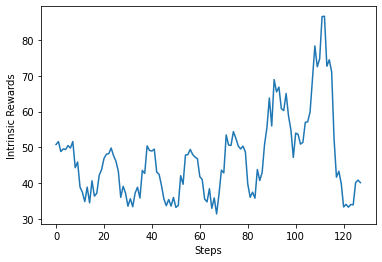

=== Rollout num. 1 ================================
[]


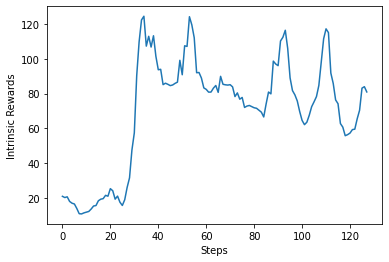

=== Rollout num. 2 ================================
[17]


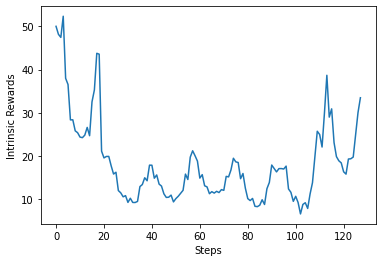

=== Rollout num. 3 ================================
[38, 60]


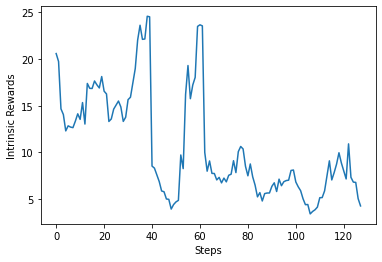

=== Rollout num. 4 ================================
[81]


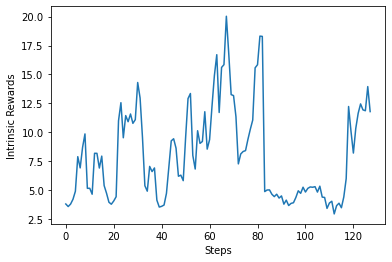

=== Rollout num. 5 ================================
[94]


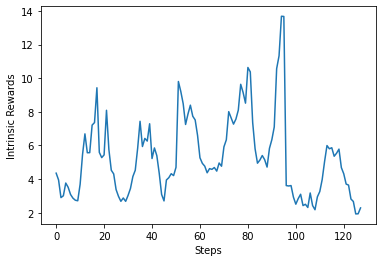

=== Rollout num. 6 ================================
[38]


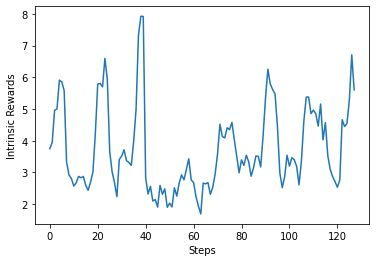

=== Rollout num. 7 ================================
[0, 55, 96]


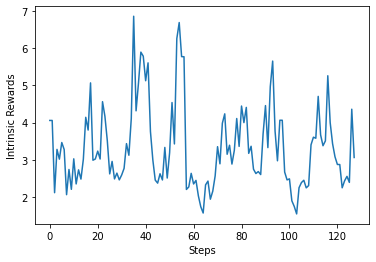

=== Rollout num. 8 ================================
[1]


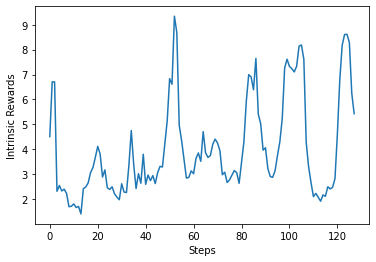

=== Rollout num. 9 ================================
[26]


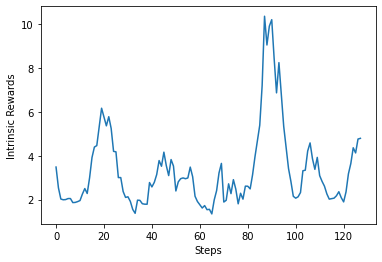

=== Rollout num. 10 ================================
[11, 42, 91]


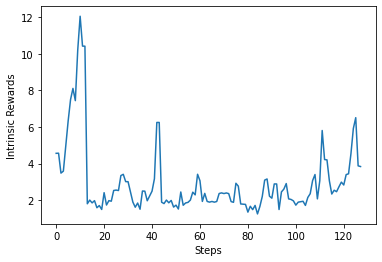

=== Rollout num. 11 ================================
[26, 59, 78, 97]


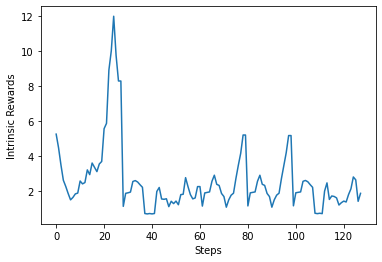

=== Rollout num. 12 ================================
[86]


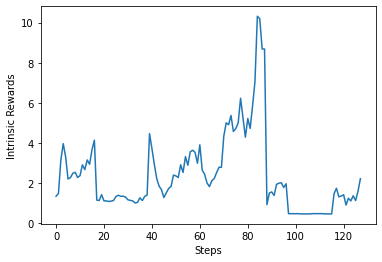

=== Rollout num. 13 ================================
[4]


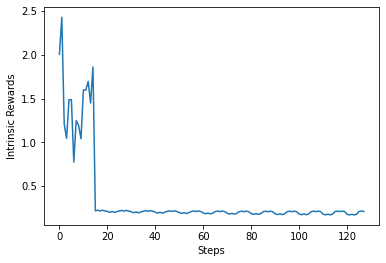

=== Rollout num. 14 ================================
[]


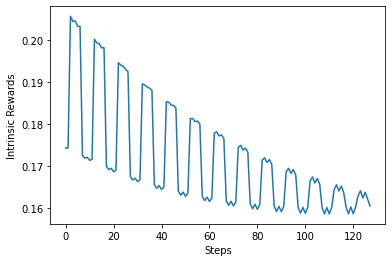

In [8]:
for i in range(len(intrinsic_rewards)):
    print("=== Rollout num. {} ================================".format(i))
    print(last_episode_step[i])

    steps = range(len(intrinsic_rewards[i])) #N_STEPS)#N_EPOCHS)

    plt.plot(steps, intrinsic_rewards[i])

    plt.xlabel("Steps")
    plt.ylabel("Intrinsic Rewards")

    plt.show()